In [177]:
import xarray as xr
import numpy as np
import dask as dask
from matplotlib import pyplot as plt
%matplotlib inline
import intake
import pandas as pd
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
import gsw

Sea water's Equation of State:
$$ \rho \simeq \rho_0 \left [ 1 - \frac{gz}{c_0^2} - \alpha_0(1 - \gamma_B z)(\Theta - \Theta_0)\frac{\gamma_C}{2}(\Theta - \Theta_0)^2 + \beta_0 (SA - S{A0} ) \right ] $$

In [178]:
#Gyre actually has the data file so instead of doing intake which takes a while when computing things, 
#you can just get it directly from Gyre using xarray zarr
ds_sose = xr.open_zarr('/swot/SUM03/tmp/SOSE')
ds_sose

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

In [179]:
ds_sose.SFLUX.units

'g/m^2/s'

In [180]:
ds_sose.TFLUX.units

'W/m^2'

# Pressure Level 0km

In [181]:
sst = ds_sose.THETA.isel(Z=0)
sss = ds_sose.SALT.isel(Z=0)

Apply ufunc is doing several things for us:

1. Feeds the raw numpy arrays to the specified function (ufunc), in this case, `gsw.SA_from_SP`.
2. It broadcast the input arrays (`sss`, `0`, `XC`, and `YC`) into compatible shapes so numpy can operate on them together.
3. It automatically parallelizes the execution across all the chunks in a dask array
4. It wraps the output back in in xarray data array

In [182]:
#lazy mode
#converting practical salinity to absolute salinity
sa = xr.apply_ufunc(gsw.SA_from_SP, sss, 0, ds_sose.XC, ds_sose.YC,
                    output_dtypes=[sss.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [183]:
#converting potential temperature to conservative temperature
ct = xr.apply_ufunc(gsw.CT_from_pt, sa, sst,
                    output_dtypes=[sss.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)


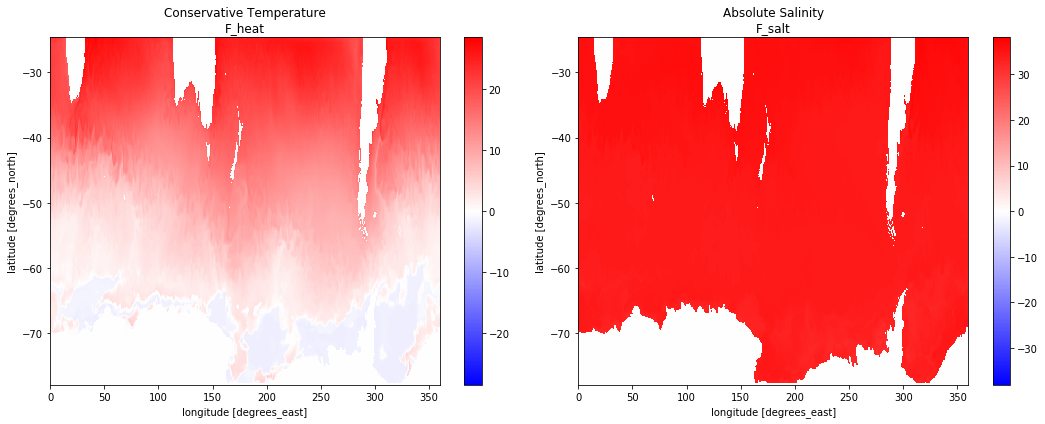

In [184]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ct[0].plot(ax=ax0, cmap='bwr')
ax0.set_title('Conservative Temperature\nF_heat')
sa[0].plot(ax=ax1, cmap='bwr')
ax1.set_title('Absolute Salinity\nF_salt')
plt.tight_layout();

## Compute density flux $$ units\ of\ \frac{kg}{m^{2}s} $$
$$
F_{\sigma} = F_{heat}\frac{\partial\sigma}{\partial\theta} + F_{salt}\frac{\partial\sigma}{\partial S}\
$$

$$
\alpha = - \frac{1}{\rho_{0}} \frac{\partial\rho}{\partial \theta}
$$

$$
\beta = \frac{1}{\rho_{0}} \frac{\partial\rho}{\partial S}
$$

In [185]:
runit2mass = 1.035e3 #rho_not
heat_capacity_cp = 3.994e3 #J/˚K/kg

## alpha at P = 0, 2000, 3000, 4000m

In [186]:
#thermal expansion coefficient
alpha_0 = xr.apply_ufunc(gsw.alpha, sa, ct, 0,
                    output_dtypes=[sst.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha_0

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [187]:
a0 = alpha_0[0].load()

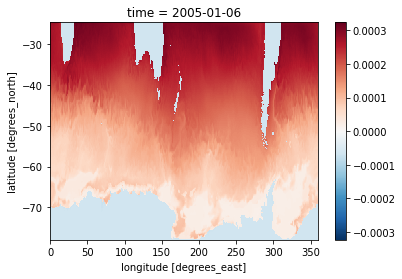

In [188]:
a0.plot()

## beta at P = 0, 2000, 3000, 4000m

In [189]:
#haline contraction coefficient
beta_0 = xr.apply_ufunc(gsw.beta, sa, ct, 0,
                      output_dtypes=[sss.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta_0

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

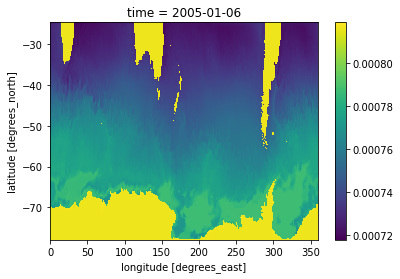

In [190]:
beta_0[0].plot()

## Temperature component of F_sigma at 4 different reference pressures

$$
F_{\sigma_{heat}} = \alpha \rho_{0} \frac{Q}{\rho_{0}c_{p}} = \alpha \frac{Q}{c_{p}}
$$

### Reference Pressure 0

In [191]:
ds_sose.TFLUX

<xarray.DataArray 'TFLUX' (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      total heat flux (match heat-content variations), >0 incre...
    standard_name:  TFLUX
    units:          W/m^2

In [192]:
F_sig_heat = (alpha_0 * ds_sose.TFLUX) / heat_capacity_cp
F_sig_heat #kg/m^2/s

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Text(0.5, 1.0, 'temperature component of\ndensity flux\nat t=0')

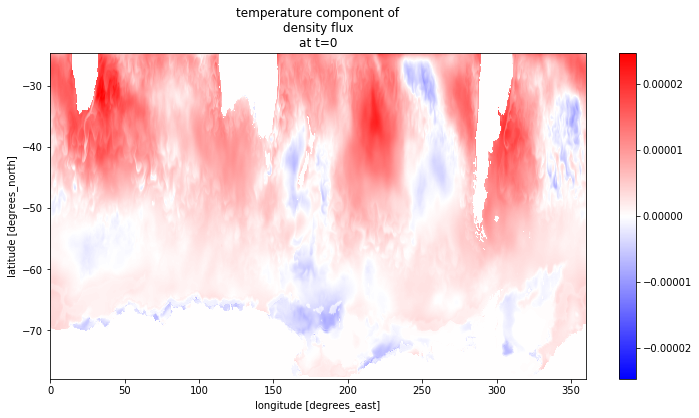

In [193]:
F_sig_heat[0].plot(figsize=(12,6), cmap='bwr')
plt.title('temperature component of\ndensity flux\nat t=0')

In [194]:
#temperature annual mean
group_time_heat = F_sig_heat.sel(time=slice('2006-01-06', '2010-12-31')).groupby('time.month').mean(dim='time')
ann_mean_heat = group_time_heat.mean(dim='month')
ann_mean_heat.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [2.088118e-06, 2.087656e-06, 2.085921e-06, ..., 2.054297e-06,
        2.067613e-06, 2.081643e-06],
       [2.177557e-06, 2.178507e-06, 2.178935e-06, ..., 2.135719e-06,
        2.150379e-06, 2.167956e-06],
       [2.222973e-06, 2.225556e-06, 2.226918e-06, ..., 2.177259e-06,
        2.191232e-06, 2.210838e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

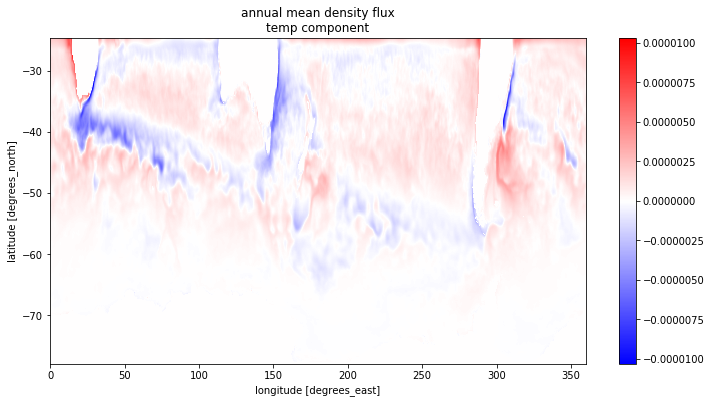

In [195]:
ann_mean_heat.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\ntemp component');

In [196]:
#OFF BY A FACTOR OF 10e-1
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_heat = (ann_mean_heat*(-9.81)*10e6) / (10*runit2mass)
buoyancy_flux_heat

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.019792, -0.019787, -0.019771, ..., -0.019471, -0.019597, -0.01973 ],
       [-0.020639, -0.020648, -0.020653, ..., -0.020243, -0.020382, -0.020548],
       [-0.02107 , -0.021094, -0.021107, ..., -0.020637, -0.020769, -0.020955]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

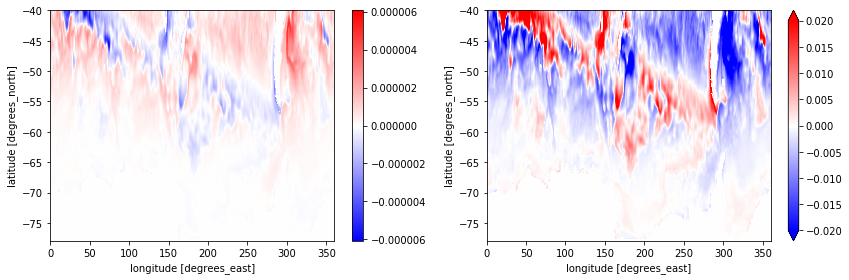

In [197]:
fig, axes = plt.subplots(figsize=(12,4), ncols=2)
ann_mean_heat.sel(YC=slice(-80,-40)).plot(ax=axes[0], cmap='bwr')
buoyancy_flux_heat.sel(YC=slice(-80,-40)).plot(ax=axes[1], cmap='bwr', vmin=-0.02, vmax=0.02)
plt.tight_layout()

Text(0.5, 1.0, 'annual mean buoyancy flux\ntemp component')

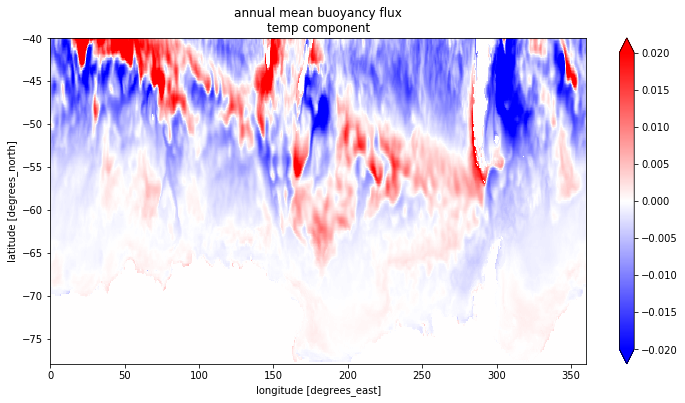

In [198]:
buoyancy_flux_heat.sel(YC=slice(-80,-40)).plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('annual mean buoyancy flux\ntemp component')

### Salinity component of F_sigma

$$
F_{\sigma_{salt}} = \beta \frac{(E-P-R)}{\rho_{fw}} = \beta*SFLUX
$$

In [199]:
F_sig_salt = beta_0 * ds_sose.SFLUX
F_sig_salt

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

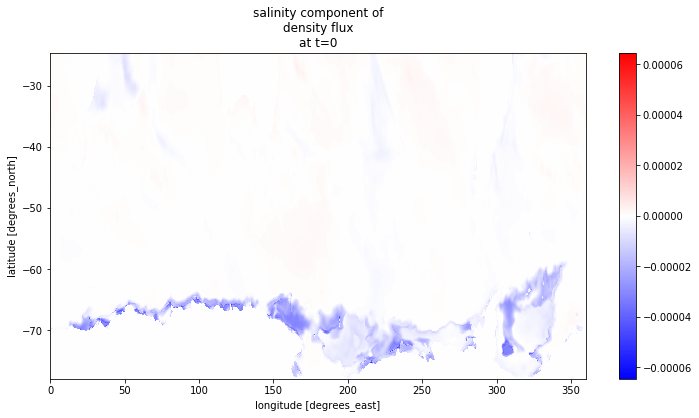

In [200]:
F_sig_salt[0].plot(figsize=(12,6), cmap='bwr')
plt.title('salinity component of\ndensity flux\nat t=0');

In [201]:
#temperature annual mean
group_time_salt = F_sig_salt.sel(time=slice('2006-01-06', '2010-12-31')).groupby('time.month').mean(dim='time')
ann_mean_salt = group_time_salt.mean(dim='month')
ann_mean_salt.load()

<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.059786e-06, 1.060849e-06, 1.061443e-06, ..., 1.054299e-06,
        1.055725e-06, 1.057688e-06],
       [1.057361e-06, 1.058215e-06, 1.058651e-06, ..., 1.053129e-06,
        1.054262e-06, 1.055729e-06],
       [1.058877e-06, 1.059617e-06, 1.060132e-06, ..., 1.055585e-06,
        1.056600e-06, 1.057648e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

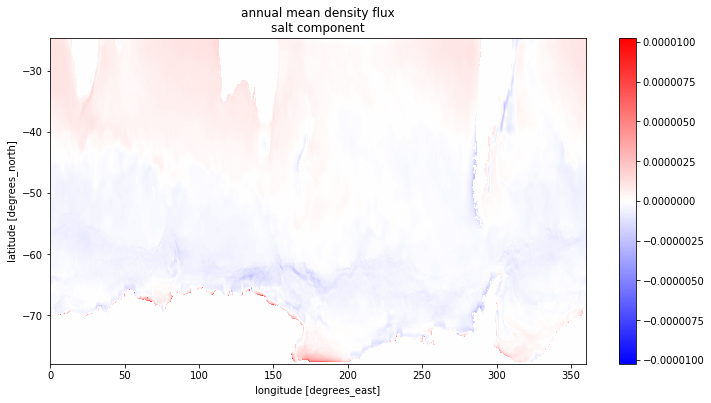

In [202]:
ann_mean_salt.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\nsalt component');

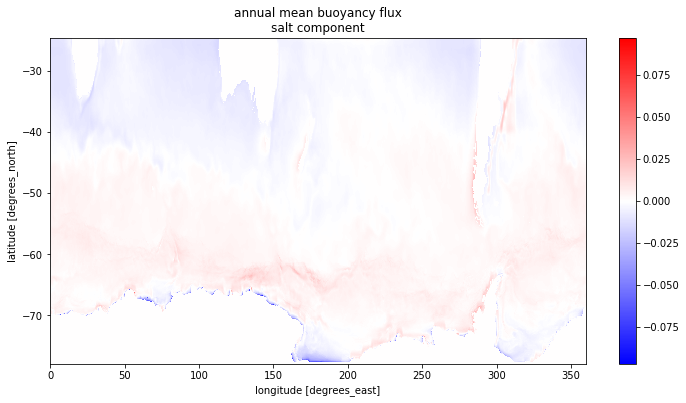

In [203]:
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_salt = ann_mean_salt*(-9.81)*10e6/ (10*runit2mass)
buoyancy_flux_salt.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\nsalt component');

## Total Buoyancy Flux at different reference pressure levels $$with\ units\ of\ \frac{mm^{2}}{s^{3}} $$

In [204]:
buoyancy_flux_total = buoyancy_flux_heat + buoyancy_flux_salt
buoyancy_flux_total

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.029837, -0.029842, -0.029832, ..., -0.029464, -0.029604, -0.029755],
       [-0.030661, -0.030678, -0.030687, ..., -0.030225, -0.030374, -0.030555],
       [-0.031106, -0.031138, -0.031156, ..., -0.030642, -0.030784, -0.03098 ]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

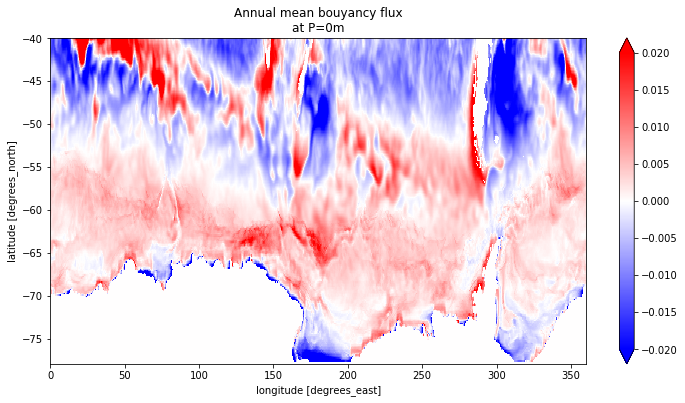

In [205]:
#perhaps it looks different from Ferrari because mine is over 5 years of sose and his is over 3
#but he doesn't specify the yrs he did the avg over
buoyancy_flux_total.sel(YC=slice(-80,-40)).plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Annual mean bouyancy flux\nat P=0m');

# Pressure Level 2km

In [206]:
ds_sose.THETA.Z.values

array([-5.0000e+00, -1.5500e+01, -2.7000e+01, -3.9500e+01, -5.3000e+01,
       -6.8000e+01, -8.5000e+01, -1.0400e+02, -1.2550e+02, -1.5000e+02,
       -1.7750e+02, -2.0850e+02, -2.4350e+02, -2.8300e+02, -3.2800e+02,
       -3.7950e+02, -4.3850e+02, -5.0600e+02, -5.8300e+02, -6.7100e+02,
       -7.7200e+02, -8.8800e+02, -1.0210e+03, -1.1735e+03, -1.3485e+03,
       -1.5495e+03, -1.7805e+03, -2.0460e+03, -2.3190e+03, -2.5750e+03,
       -2.8250e+03, -3.0750e+03, -3.3250e+03, -3.5750e+03, -3.8250e+03,
       -4.0750e+03, -4.3250e+03, -4.5750e+03, -4.8250e+03, -5.0750e+03,
       -5.3250e+03, -5.5750e+03], dtype=float32)

In [207]:
sst_2 = ds_sose.THETA.sel(Z=-2e3, method='nearest')
sss_2 = ds_sose.SALT.sel(Z=-2e3, method='nearest')

In [208]:
#lazy mode
#converting practical salinity to absolute salinity
sa_2 = xr.apply_ufunc(gsw.SA_from_SP, sss_2, 2000, ds_sose.XC, ds_sose.YC,
                    output_dtypes=[sss_2.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_2

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [209]:
#converting potential temperature to conservative temperature
ct_2 = xr.apply_ufunc(gsw.CT_from_pt, sa_2, sst_2,
                    output_dtypes=[sss_2.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct_2

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)


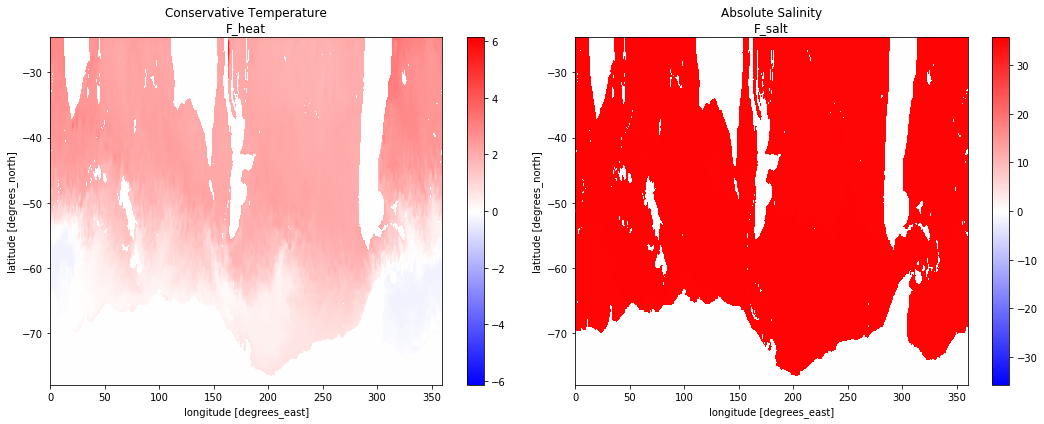

In [210]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ct_2[0].plot(ax=ax0, cmap='bwr')
ax0.set_title('Conservative Temperature\nF_heat')
sa_2[0].plot(ax=ax1, cmap='bwr')
ax1.set_title('Absolute Salinity\nF_salt')
plt.tight_layout();

## Compute Density Flux

In [211]:
runit2mass = 1.035e3 #rho_not
heat_capacity_cp = 3.994e3 #J/˚K/kg

### alpha at P=2km

In [212]:
alpha_2 = xr.apply_ufunc(gsw.alpha, sa_2, ct_2, 2000,
                    output_dtypes=[sst_2.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha_2

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [213]:
a2 = alpha_2[0].load()

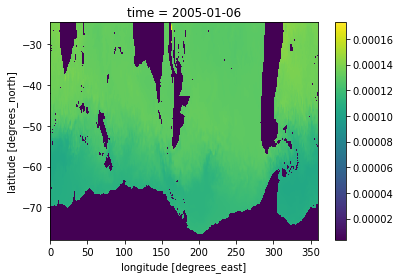

In [214]:
a2.plot()

### beta at P=2km

In [215]:
beta_2 = xr.apply_ufunc(gsw.beta, sa_2, ct_2, 2000,
                      output_dtypes=[sss_2.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta_2

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [216]:
b2 = beta_2[0].load()

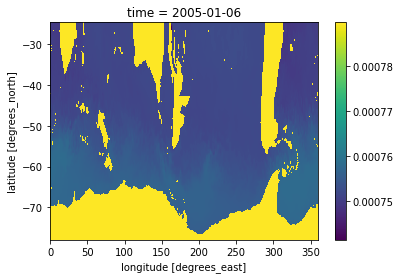

In [217]:
b2.plot()

## Temperature component of F_sigma at 2km

In [218]:
F_sig_heat_2 = (alpha_2 * ds_sose.TFLUX) / heat_capacity_cp
F_sig_heat_2 #kg/m^2/s

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Text(0.5, 1.0, 'temperature component of\ndensity flux\nat t=0')

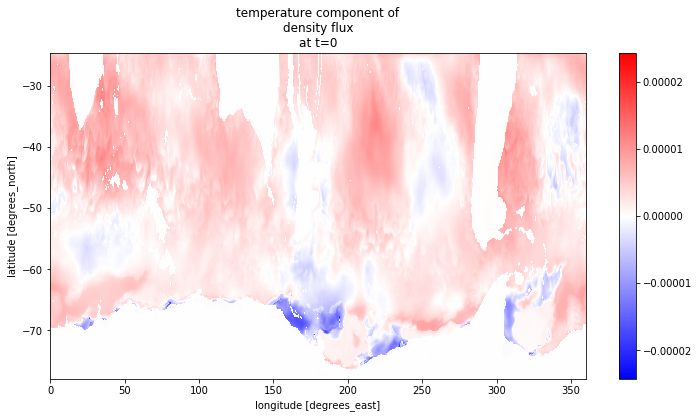

In [219]:
F_sig_heat_2[0].plot(figsize=(12,6), cmap='bwr')
plt.title('temperature component of\ndensity flux\nat t=0')

In [220]:
#temperature annual mean
group_time_heat_2 = F_sig_heat_2.sel(time=slice('2006-01-06', '2010-12-31')).groupby('time.month').mean(dim='time')
ann_mean_heat_2 = group_time_heat_2.mean(dim='month')
ann_mean_heat_2.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.049232e-06, 1.050640e-06, 1.051384e-06, ..., 1.027054e-06,
        1.035492e-06, 1.044287e-06],
       [1.098336e-06, 1.100521e-06, 1.102471e-06, ..., 1.071810e-06,
        1.081006e-06, 1.091702e-06],
       [1.126430e-06, 1.129405e-06, 1.131819e-06, ..., 1.097920e-06,
        1.106771e-06, 1.118496e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

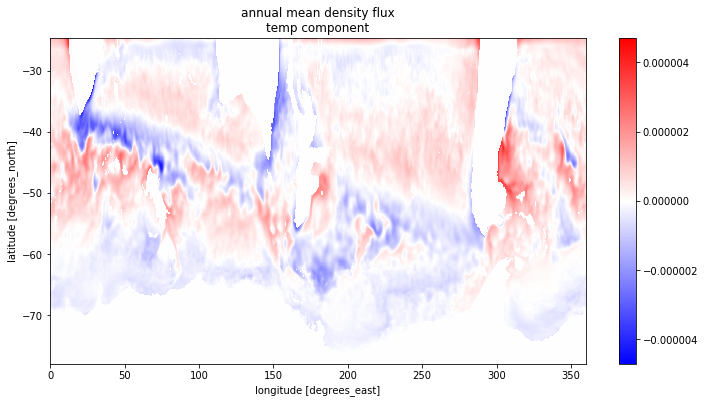

In [221]:
ann_mean_heat_2.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\ntemp component');

In [222]:
#OFF BY A FACTOR OF 10e-1
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_heat_2 = (ann_mean_heat_2*(-9.81)*10e6) / (10*runit2mass)
buoyancy_flux_heat_2

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.009945, -0.009958, -0.009965, ..., -0.009735, -0.009815, -0.009898],
       [-0.01041 , -0.010431, -0.01045 , ..., -0.010159, -0.010246, -0.010347],
       [-0.010677, -0.010705, -0.010728, ..., -0.010406, -0.01049 , -0.010601]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

Text(0.5, 1.0, 'annual mean buoyancy flux\ntemp component')

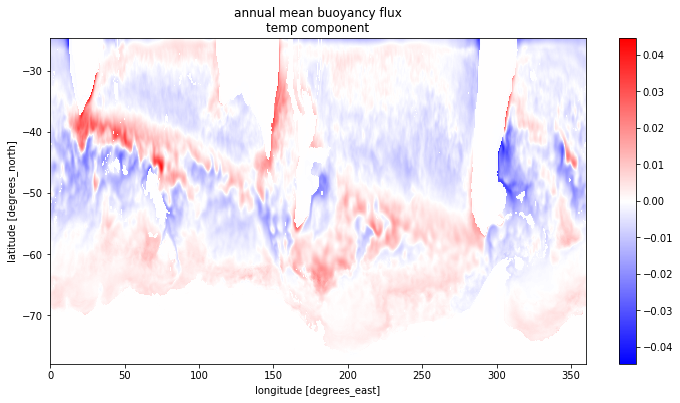

In [223]:
buoyancy_flux_heat_2.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\ntemp component')

### Salinity component of F_sigma

$$
F_{\sigma_{salt}} = \beta \frac{(E-P-R)}{\rho_{fw}} = \beta*SFLUX
$$

In [224]:
F_sig_salt_2 = beta_2 * ds_sose.SFLUX
F_sig_salt_2

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

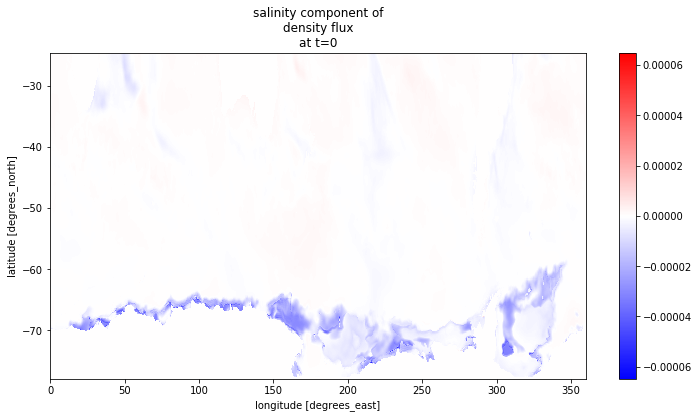

In [225]:
F_sig_salt_2[0].plot(figsize=(12,6), cmap='bwr')
plt.title('salinity component of\ndensity flux\nat t=0');

In [226]:
#temperature annual mean
group_time_salt_2 = F_sig_salt_2.sel(time=slice('2006-01-06', '2010-12-31')).groupby('time.month').mean(dim='time')
ann_mean_salt_2 = group_time_salt_2.mean(dim='month')
ann_mean_salt_2.load()

<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.087393e-06, 1.088388e-06, 1.088905e-06, ..., 1.082036e-06,
        1.083410e-06, 1.085333e-06],
       [1.084890e-06, 1.085672e-06, 1.086026e-06, ..., 1.080825e-06,
        1.081897e-06, 1.083309e-06],
       [1.086464e-06, 1.087130e-06, 1.087568e-06, ..., 1.083363e-06,
        1.084315e-06, 1.085296e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

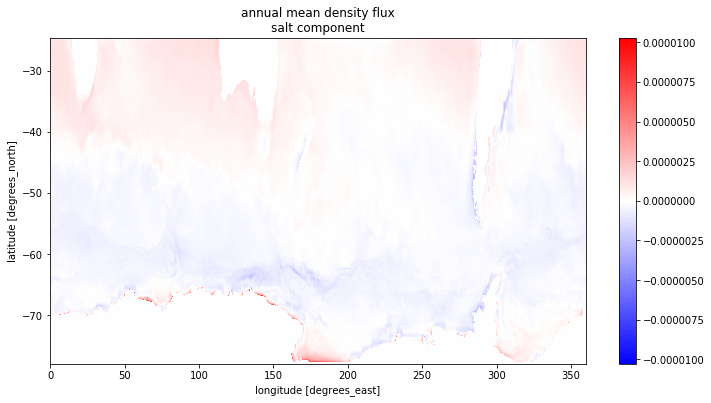

In [227]:
ann_mean_salt_2.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\nsalt component');

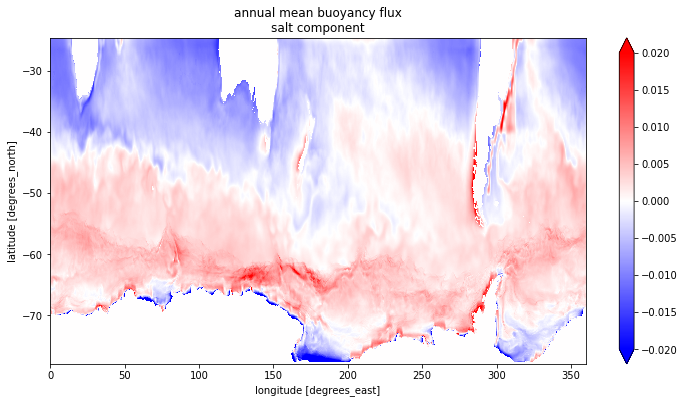

In [228]:
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_salt_2 = ann_mean_salt_2*(-9.81)*10e6/ (10*runit2mass)
buoyancy_flux_salt_2.plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('annual mean buoyancy flux\nsalt component');

## Total Buoyancy Flux at  reference pressure level 2km $$with\ units\ of\ \frac{mm^{2}}{s^{3}} $$

In [229]:
buoyancy_flux_total_2 = buoyancy_flux_heat_2 + buoyancy_flux_salt_2
buoyancy_flux_total_2

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.020251, -0.020274, -0.020286, ..., -0.019991, -0.020084, -0.020185],
       [-0.020693, -0.020721, -0.020743, ..., -0.020403, -0.020501, -0.020615],
       [-0.020974, -0.021009, -0.021036, ..., -0.020675, -0.020768, -0.020888]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

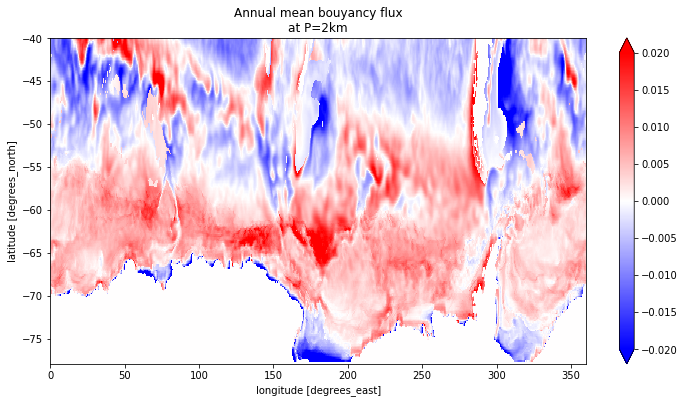

In [230]:
#perhaps it looks different from Ferrari because mine is over 5 years of sose and his is over 3
#but he doesn't specify the yrs he did the avg over
buoyancy_flux_total_2.sel(YC=slice(-80,-40)).plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Annual mean bouyancy flux\nat P=2km');

# Pressure Level 3km

In [231]:
sst_3 = ds_sose.THETA.sel(Z=-3e3, method='nearest')
sss_3 = ds_sose.SALT.sel(Z=-3e3, method='nearest')

In [232]:
#lazy mode
#converting practical salinity to absolute salinity
sa_3 = xr.apply_ufunc(gsw.SA_from_SP, sss_3, 3000, ds_sose.XC, ds_sose.YC,
                    output_dtypes=[sss_3.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_3

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [233]:
#converting potential temperature to conservative temperature
ct_3 = xr.apply_ufunc(gsw.CT_from_pt, sa_3, sst_3,
                    output_dtypes=[sss_3.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct_3

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)


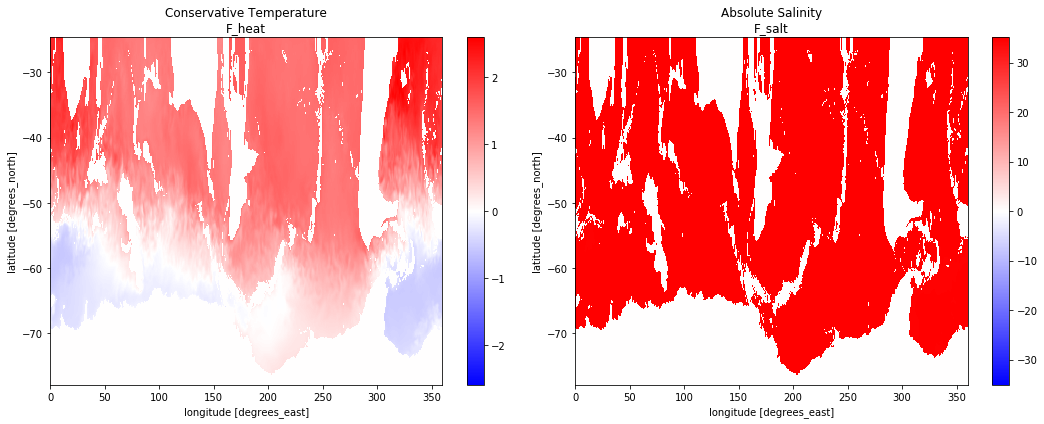

In [234]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ct_3[0].plot(ax=ax0, cmap='bwr')
ax0.set_title('Conservative Temperature\nF_heat')
sa_3[0].plot(ax=ax1, cmap='bwr')
ax1.set_title('Absolute Salinity\nF_salt')
plt.tight_layout();

## Compute Density Flux

In [235]:
runit2mass = 1.035e3 #rho_not
heat_capacity_cp = 3.994e3 #J/˚K/kg

### alpha at P=3km

In [236]:
alpha_3 = xr.apply_ufunc(gsw.alpha, sa_3, ct_3, 3000,
                    output_dtypes=[sst_3.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha_3

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [237]:
a3 = alpha_3[0].load()

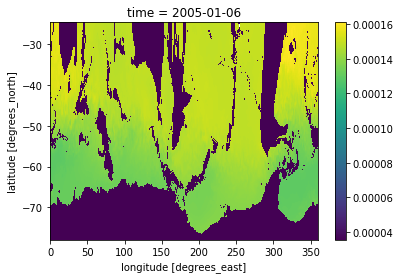

In [238]:
a3.plot()

### beta at P=3km

In [239]:
beta_3 = xr.apply_ufunc(gsw.beta, sa_3, ct_3, 3000,
                      output_dtypes=[sss_3.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta_3

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [240]:
b3 = beta_3[0].load()

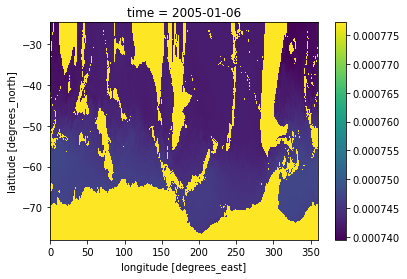

In [241]:
b3.plot()

## Temperature component of F_sigma at 3km

In [242]:
F_sig_heat_3 = (alpha_3 * ds_sose.TFLUX) / heat_capacity_cp
F_sig_heat_3 #kg/m^2/s

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Text(0.5, 1.0, 'temperature component of\ndensity flux\nat t=0')

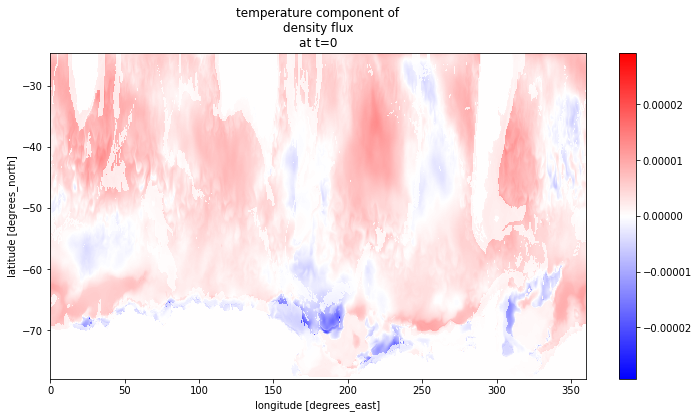

In [243]:
F_sig_heat_3[0].plot(figsize=(12,6), cmap='bwr')
plt.title('temperature component of\ndensity flux\nat t=0')

In [244]:
#temperature annual mean
group_time_heat_3 = F_sig_heat_3.sel(time=slice('2006-01-06', '2010-12-31')).groupby('time.month').mean(dim='time')
ann_mean_heat_3 = group_time_heat_3.mean(dim='month')
ann_mean_heat_3.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.190823e-06, 1.192169e-06, 1.192759e-06, ..., 1.166388e-06,
        1.175730e-06, 1.185463e-06],
       [1.246506e-06, 1.248717e-06, 1.250657e-06, ..., 1.217160e-06,
        1.227358e-06, 1.239240e-06],
       [1.278917e-06, 1.282040e-06, 1.284523e-06, ..., 1.247296e-06,
        1.257098e-06, 1.270163e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

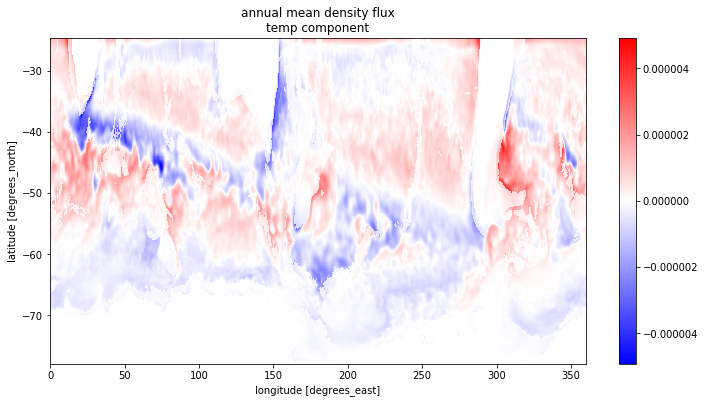

In [245]:
ann_mean_heat_3.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\ntemp component');

In [246]:
#OFF BY A FACTOR OF 10e-1
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_heat_3 = (ann_mean_heat_3*(-9.81)*10e6) / (10*runit2mass)
buoyancy_flux_heat_3

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.011287, -0.0113  , -0.011305, ..., -0.011055, -0.011144, -0.011236],
       [-0.011815, -0.011836, -0.011854, ..., -0.011537, -0.011633, -0.011746],
       [-0.012122, -0.012152, -0.012175, ..., -0.011822, -0.011915, -0.012039]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

Text(0.5, 1.0, 'annual mean buoyancy flux\ntemp component')

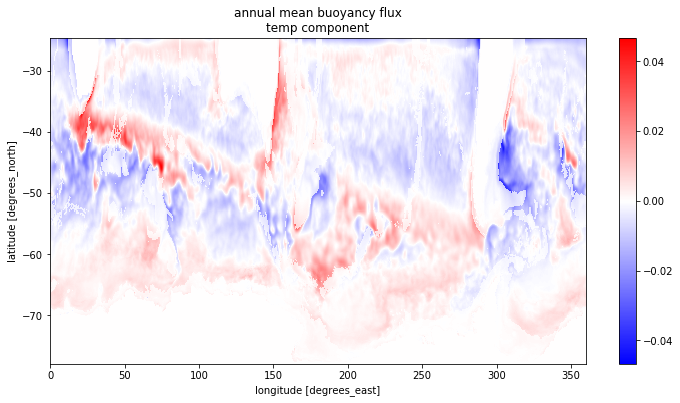

In [247]:
buoyancy_flux_heat_3.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\ntemp component')

### Salinity component of F_sigma

$$
F_{\sigma_{salt}} = \beta \frac{(E-P-R)}{\rho_{fw}} = \beta*SFLUX
$$

In [248]:
F_sig_salt_3 = beta_3 * ds_sose.SFLUX
F_sig_salt_3

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

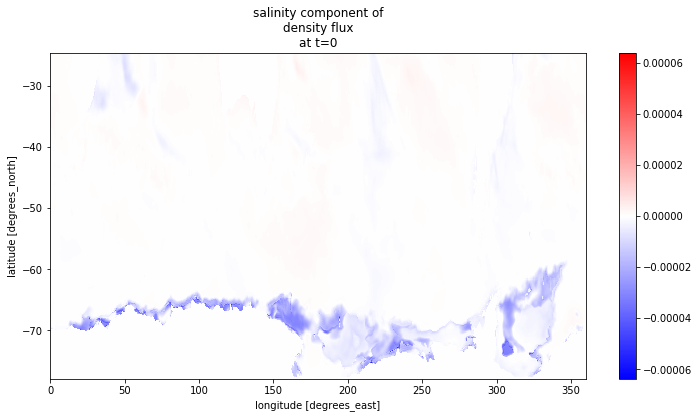

In [249]:
F_sig_salt_3[0].plot(figsize=(12,6), cmap='bwr')
plt.title('salinity component of\ndensity flux\nat t=0');

In [250]:
#temperature annual mean
group_time_salt_3 = F_sig_salt_3.sel(time=slice('2006-01-06', '2010-12-31')).groupby('time.month').mean(dim='time')
ann_mean_salt_3 = group_time_salt_3.mean(dim='month')
ann_mean_salt_3.load()

<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.073806e-06, 1.074799e-06, 1.075319e-06, ..., 1.068486e-06,
        1.069853e-06, 1.071762e-06],
       [1.071338e-06, 1.072120e-06, 1.072479e-06, ..., 1.067294e-06,
        1.068363e-06, 1.069767e-06],
       [1.072872e-06, 1.073538e-06, 1.073980e-06, ..., 1.069782e-06,
        1.070731e-06, 1.071709e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

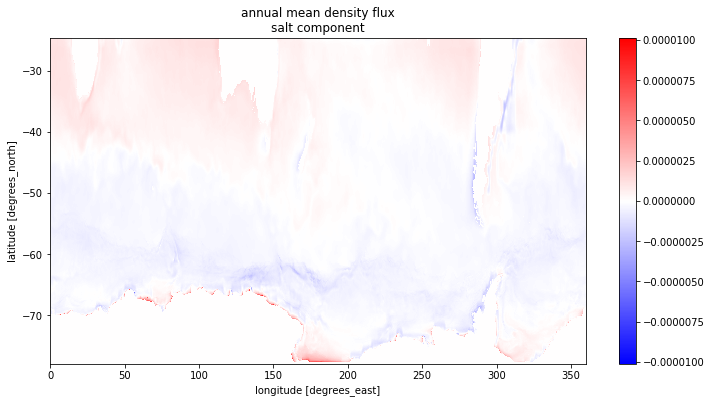

In [251]:
ann_mean_salt_3.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\nsalt component');

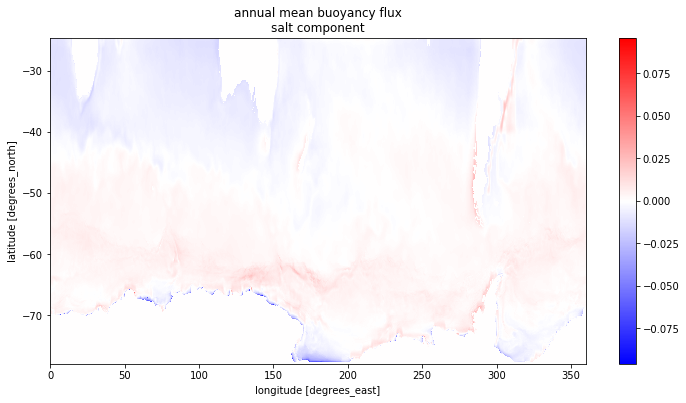

In [252]:
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_salt_3 = ann_mean_salt_3*(-9.81)*10e6/ (10*runit2mass)
buoyancy_flux_salt_3.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\nsalt component');

## Total Buoyancy Flux at reference pressure 3km $$with\ units\ of\ \frac{mm^{2}}{s^{3}} $$

In [253]:
buoyancy_flux_total_3 = buoyancy_flux_heat_3 + buoyancy_flux_salt_3
buoyancy_flux_total_3

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.021465, -0.021487, -0.021497, ..., -0.021183, -0.021284, -0.021395],
       [-0.021969, -0.021997, -0.022019, ..., -0.021653, -0.021759, -0.021885],
       [-0.022291, -0.022327, -0.022355, ..., -0.021962, -0.022064, -0.022197]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

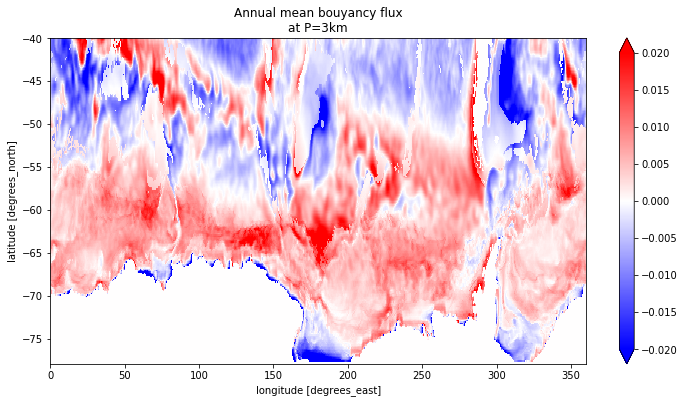

In [254]:
#perhaps it looks different from Ferrari because mine is over 5 years of sose and his is over 3
#but he doesn't specify the yrs he did the avg over
buoyancy_flux_total_3.sel(YC=slice(-80,-40)).plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Annual mean bouyancy flux\nat P=3km');

# Pressure Level 4km

In [255]:
sst_4 = ds_sose.THETA.sel(Z=-4e3, method='nearest')
sss_4 = ds_sose.SALT.sel(Z=-4e3, method='nearest')

In [256]:
#lazy mode
#converting practical salinity to absolute salinity
sa_4 = xr.apply_ufunc(gsw.SA_from_SP, sss_4, 4000, ds_sose.XC, ds_sose.YC,
                    output_dtypes=[sss_4.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_4

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [257]:
#converting potential temperature to conservative temperature
ct_4 = xr.apply_ufunc(gsw.CT_from_pt, sa_4, sst_4,
                    output_dtypes=[sss_4.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct_4

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)


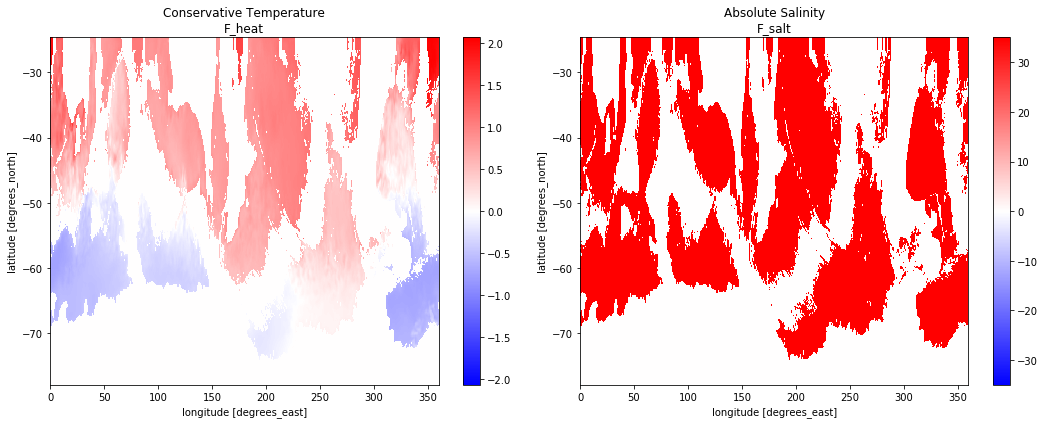

In [258]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ct_4[0].plot(ax=ax0, cmap='bwr')
ax0.set_title('Conservative Temperature\nF_heat')
sa_4[0].plot(ax=ax1, cmap='bwr')
ax1.set_title('Absolute Salinity\nF_salt')
plt.tight_layout();

## Compute Density Flux

In [259]:
runit2mass = 1.035e3 #rho_not
heat_capacity_cp = 3.994e3 #J/˚K/kg

### alpha at P=4km

In [260]:
alpha_4 = xr.apply_ufunc(gsw.alpha, sa_4, ct_4, 4000,
                    output_dtypes=[sst_4.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha_4

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [261]:
a4 = alpha_4[0].load()

In [313]:
a0.load()

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-6.410533e-05, -6.410533e-05, -6.410533e-05, ..., -6.410533e-05,
        -6.410533e-05, -6.410533e-05],
       [-6.410533e-05, -6.410533e-05, -6.410533e-05, ..., -6.410533e-05,
        -6.410533e-05, -6.410533e-05],
       [-6.410533e-05, -6.410533e-05, -6.410533e-05, ..., -6.410533e-05,
        -6.410533e-05, -6.410533e-05],
       ...,
       [ 2.743353e-04,  2.741900e-04,  2.740019e-04, ...,  2.748296e-04,
         2.746238e-04,  2.744759e-04],
       [ 2.755858e-04,  2.754129e-04,  2.752364e-04, ...,  2.760834e-04,
         2.759209e-04,  2.757555e-04],
       [ 2.763511e-04,  2.762343e-04,  2.761175e-04, ...,  2.767013e-04,
         2.765846e-04,  2.764679e-04]])
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    time     datetime64[ns] 2005-01-06

### beta at P=4km

In [263]:
beta_4 = xr.apply_ufunc(gsw.beta, sa_4, ct_4, 4000,
                      output_dtypes=[sss_4.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta_4

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [264]:
b4 = beta_4[0].load()

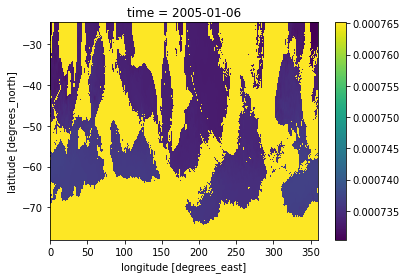

In [265]:
b4.plot()

## Temperature component of F_sigma at 4km

In [266]:
F_sig_heat_4 = (alpha_4 * ds_sose.TFLUX) / heat_capacity_cp
F_sig_heat_4 #kg/m^2/s

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Text(0.5, 1.0, 'temperature component of\ndensity flux\nat t=0')

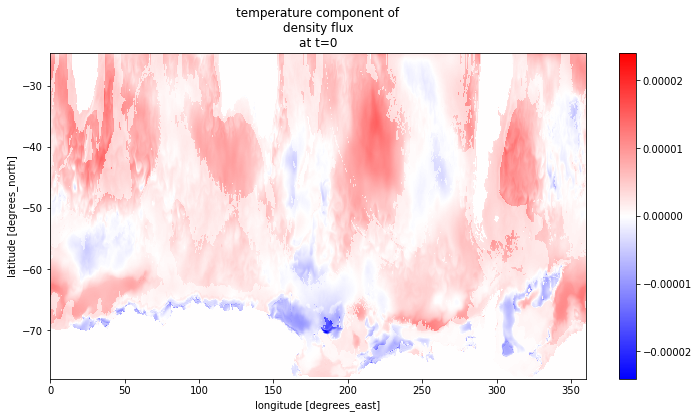

In [267]:
F_sig_heat_4[0].plot(figsize=(12,6), cmap='bwr')
plt.title('temperature component of\ndensity flux\nat t=0')

In [268]:
#temperature annual mean
group_time_heat_4 = F_sig_heat_4.sel(time=slice('2006-01-06', '2010-12-31')).groupby('time.month').mean(dim='time')
ann_mean_heat_4 = group_time_heat_4.mean(dim='month')
ann_mean_heat_4.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.359439e-06, 1.360956e-06, 1.361605e-06, ..., 1.331597e-06,
        1.342242e-06, 1.353334e-06],
       [1.422984e-06, 1.425491e-06, 1.427687e-06, ..., 1.389550e-06,
        1.401169e-06, 1.414711e-06],
       [1.460084e-06, 1.463638e-06, 1.466459e-06, ..., 1.424027e-06,
        1.435202e-06, 1.450103e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

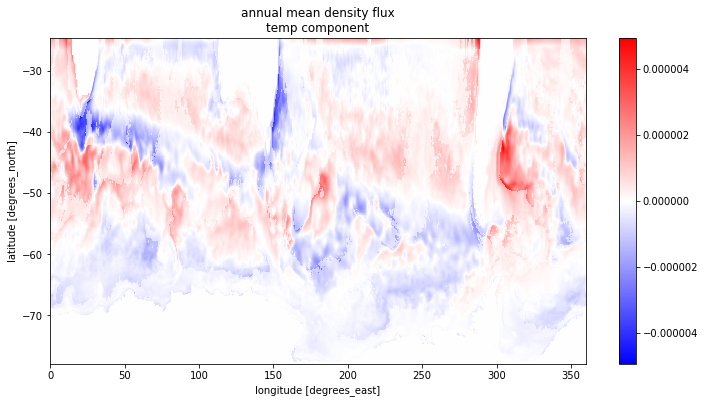

In [269]:
ann_mean_heat_4.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\ntemp component');

In [270]:
#OFF BY A FACTOR OF 10e-1
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_heat_4 = (ann_mean_heat_4*(-9.81)*10e6) / (10*runit2mass)
buoyancy_flux_heat_4

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.012885, -0.012899, -0.012906, ..., -0.012621, -0.012722, -0.012827],
       [-0.013487, -0.013511, -0.013532, ..., -0.013171, -0.013281, -0.013409],
       [-0.013839, -0.013873, -0.013899, ..., -0.013497, -0.013603, -0.013744]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

Text(0.5, 1.0, 'annual mean buoyancy flux\ntemp component')

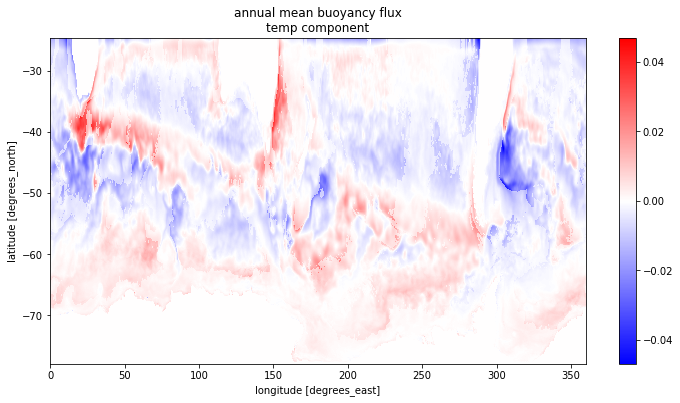

In [271]:
buoyancy_flux_heat_4.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\ntemp component')

### Salinity component of F_sigma

$$
F_{\sigma_{salt}} = \beta \frac{(E-P-R)}{\rho_{fw}} = \beta*SFLUX
$$

In [272]:
F_sig_salt_4 = beta_4 * ds_sose.SFLUX
F_sig_salt_4

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

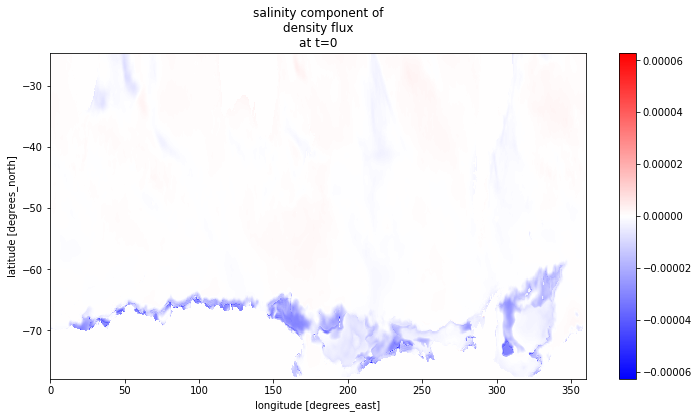

In [273]:
F_sig_salt_4[0].plot(figsize=(12,6), cmap='bwr')
plt.title('salinity component of\ndensity flux\nat t=0');

In [274]:
#temperature annual mean
group_time_salt_4 = F_sig_salt_4.sel(time=slice('2006-01-06', '2010-12-31')).groupby('time.month').mean(dim='time')
ann_mean_salt_4 = group_time_salt_4.mean(dim='month')
ann_mean_salt_4.load()

<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.059158e-06, 1.060139e-06, 1.060654e-06, ..., 1.053906e-06,
        1.055256e-06, 1.057141e-06],
       [1.056724e-06, 1.057497e-06, 1.057853e-06, ..., 1.052730e-06,
        1.053786e-06, 1.055172e-06],
       [1.058233e-06, 1.058892e-06, 1.059329e-06, ..., 1.055181e-06,
        1.056119e-06, 1.057085e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

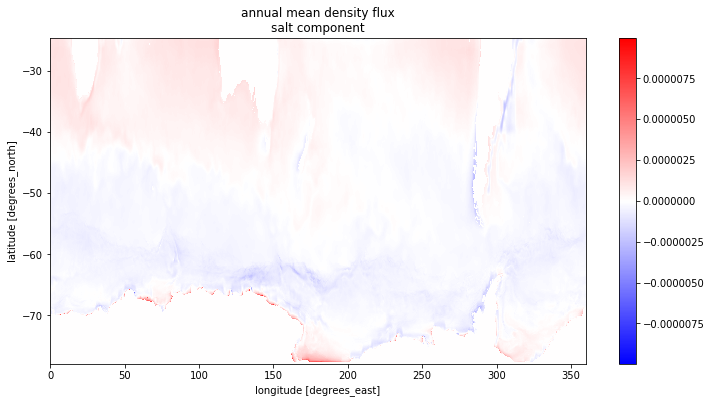

In [275]:
ann_mean_salt_4.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\nsalt component');

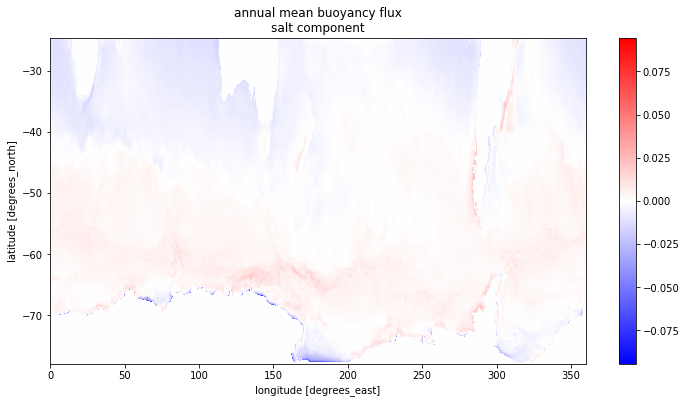

In [276]:
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_salt_4 = ann_mean_salt_4*(-9.81)*10e6/ (10*runit2mass)
buoyancy_flux_salt_4.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\nsalt component');

## Total Buoyancy Flux at different pressure 4km $$with\ units\ of\ \frac{mm^{2}}{s^{3}} $$

In [277]:
buoyancy_flux_total_4 = buoyancy_flux_heat_4 + buoyancy_flux_salt_4
buoyancy_flux_total_4

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.022924, -0.022948, -0.022959, ..., -0.02261 , -0.022724, -0.022847],
       [-0.023503, -0.023534, -0.023559, ..., -0.023149, -0.023269, -0.02341 ],
       [-0.023869, -0.023909, -0.02394 , ..., -0.023499, -0.023613, -0.023764]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

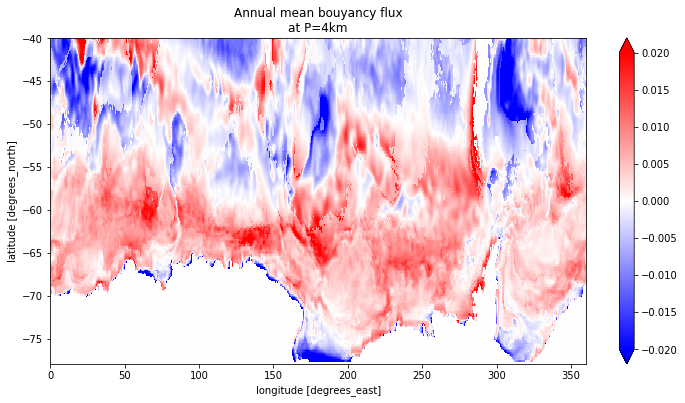

In [278]:
#perhaps it looks different from Ferrari because mine is over 5 years of sose and his is over 3
#but he doesn't specify the yrs he did the avg over
buoyancy_flux_total_4.sel(YC=slice(-80,-40)).plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Annual mean bouyancy flux\nat P=4km');

# Compilation of T/S buoyancy fluxes at the 4 different reference levels

In [279]:
buoyancy_flux_heat = -buoyancy_flux_heat
buoyancy_flux_heat_2 = -buoyancy_flux_heat_2
buoyancy_flux_heat_3 = -buoyancy_flux_heat_3
buoyancy_flux_heat_4 = -buoyancy_flux_heat_4


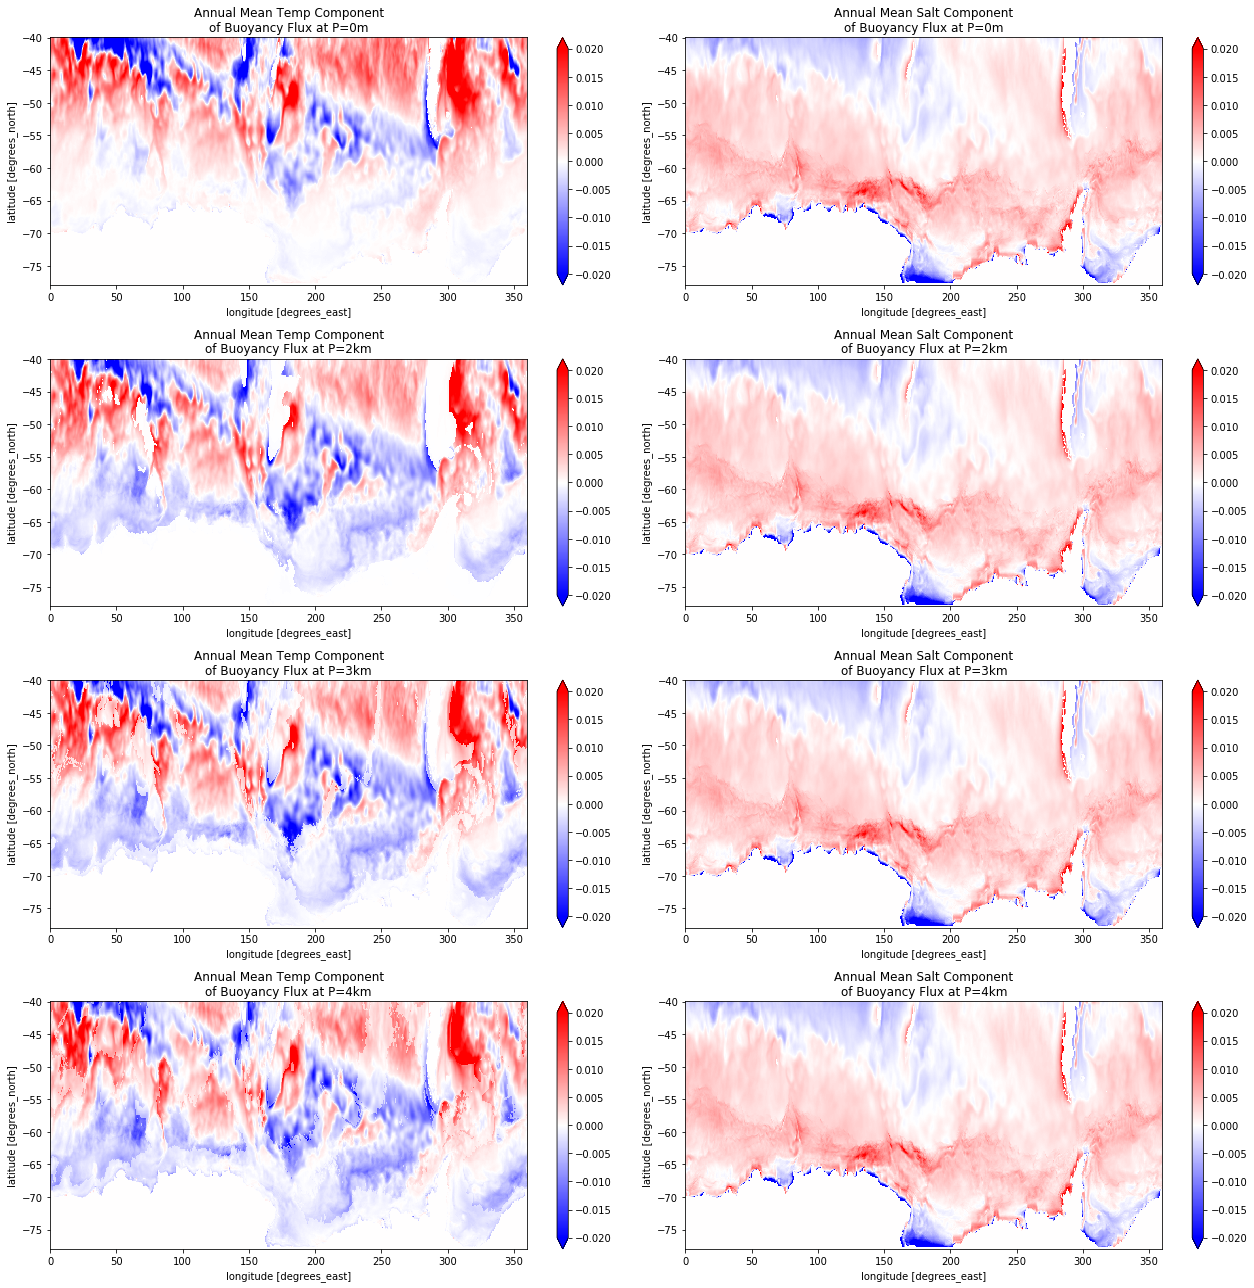

In [280]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(18,18))#, sharex=True, sharey=True)

buoyancy_flux_heat.sel(YC=slice(-80,-40)).plot(ax=axes[0,0], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[0,0].set_title('Annual Mean Temp Component\nof Buoyancy Flux at P=0m')
buoyancy_flux_salt.sel(YC=slice(-80,-40)).plot(ax=axes[0,1], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[0,1].set_title('Annual Mean Salt Component\nof Buoyancy Flux at P=0m')

buoyancy_flux_heat_2.sel(YC=slice(-80,-40)).plot(ax=axes[1,0], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[1,0].set_title('Annual Mean Temp Component\nof Buoyancy Flux at P=2km')
buoyancy_flux_salt_2.sel(YC=slice(-80,-40)).plot(ax=axes[1,1], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[1,1].set_title('Annual Mean Salt Component\nof Buoyancy Flux at P=2km')

buoyancy_flux_heat_3.sel(YC=slice(-80,-40)).plot(ax=axes[2,0], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[2,0].set_title('Annual Mean Temp Component\nof Buoyancy Flux at P=3km')
buoyancy_flux_salt_3.sel(YC=slice(-80,-40)).plot(ax=axes[2,1], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[2,1].set_title('Annual Mean Salt Component\nof Buoyancy Flux at P=3km')

buoyancy_flux_heat_4.sel(YC=slice(-80,-40)).plot(ax=axes[3,0], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[3,0].set_title('Annual Mean Temp Component\nof Buoyancy Flux at P=4km')
buoyancy_flux_salt_4.sel(YC=slice(-80,-40)).plot(ax=axes[3,1], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[3,1].set_title('Annual Mean Salt Component\nof Buoyancy Flux at P=4km')

plt.tight_layout();

In [281]:
buoyancy_flux = xr.merge([buoyancy_flux_heat.to_dataset(name='buoyancy_flux_heat'),
                          buoyancy_flux_heat.to_dataset(name='buoyancy_flux_heat_4'),
                          buoyancy_flux_salt.to_dataset(name='buoyancy_flux_salt'),
                          buoyancy_flux_salt_4.to_dataset(name='buoyancy_flux_salt_4')])
buoyancy_flux.XC.values

array([8.3333336e-02, 2.5000000e-01, 4.1666669e-01, ..., 3.5958334e+02,
       3.5975000e+02, 3.5991669e+02], dtype=float32)

In [282]:
#changing buoyancy_flux ds longitudinal coords to be -180<XC<180
ds1_buoyancy_flux = buoyancy_flux.roll(XC=-1).copy()
ds_buoyancy_flux = ds1_buoyancy_flux.drop('XC')
XC = ds1_buoyancy_flux.XC.data
XC[XC>180.] -= 360.
ds_buoyancy_flux.coords['XC'] = ('XC', XC)
ds_buoyancy_flux.XC

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  from ipykernel import kernelapp as app


<xarray.DataArray 'XC' (XC: 2160)>
array([ 0.25    ,  0.416667,  0.583333, ..., -0.25    , -0.083313,  0.083333],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.25 0.4166667 0.5833334 ... -0.08331299 0.083333336

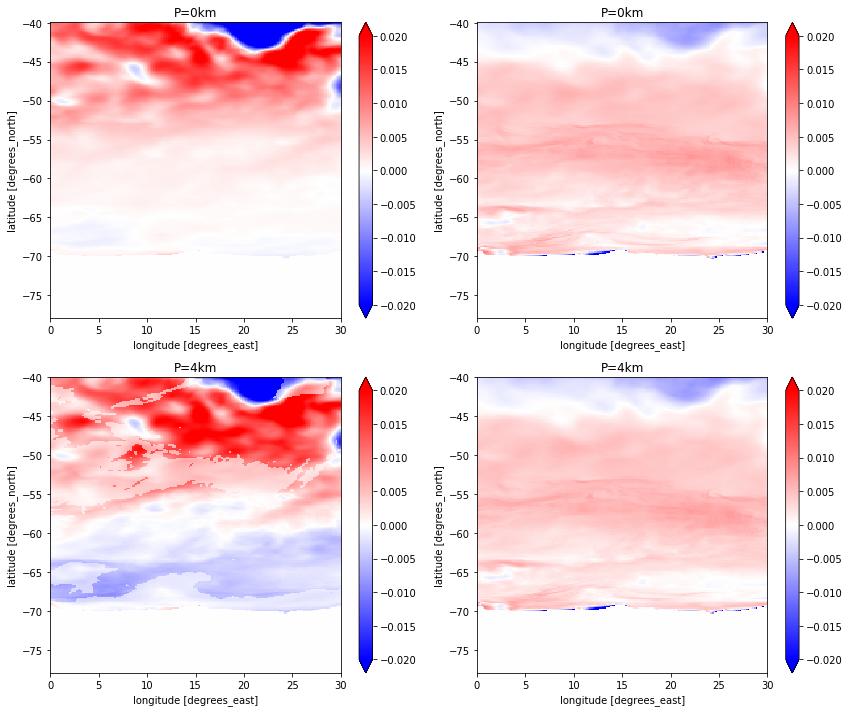

In [283]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,10))
fig = plt.gcf()

#fig.suptitle('Annual Mean Buoyancy Flux\nSalinity Component', y=1.03, x=0.8, fontsize=14, weight='bold')
#fig.suptitle('Annual Mean Buoyancy Flux\nTemperature Component', y=1.03, x=0.2, fontsize=14, weight='bold')

buoyancy_flux_heat.sel(YC=slice(-80,-40), XC=slice(-75,30)).plot(ax=axes[0,0], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[0,0].set_title('P=0km')

buoyancy_flux_heat_4.sel(YC=slice(-80,-40), XC=slice(-75,30)).plot(ax=axes[1,0], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[1,0].set_title('P=4km')

buoyancy_flux_salt.sel(YC=slice(-80,-40), XC=slice(-75,30)).plot(ax=axes[0,1], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[0,1].set_title('P=0km')

buoyancy_flux_salt_4.sel(YC=slice(-80,-40), XC=slice(-75,30)).plot(ax=axes[1,1], cmap='bwr', vmin=-0.02, vmax=0.02)
axes[1,1].set_title('P=4km')

plt.tight_layout();

In [284]:
seaice_groupby = ds_sose.SIarea.groupby('time.month').where(ds_sose.hFacC[0]>0).mean(dim='time')
seaice_groupby.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'SIarea' (YC: 320, XC: 2160)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0
    PHrefC   float32 49.05
    Z        float32 -5.0
    drF      float32 10.0
    hFacC    (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0

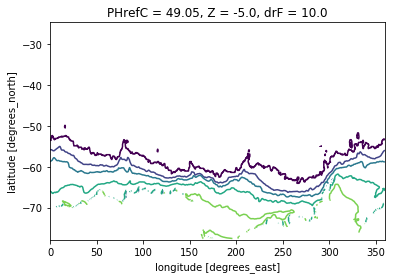

In [285]:
seaice_groupby.plot.contour()

In [286]:
ds_sose.time

<xarray.DataArray 'time' (time: 438)>
array(['2005-01-06T00:00:00.000000000', '2005-01-11T00:00:00.000000000',
       '2005-01-16T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

# Ryan's

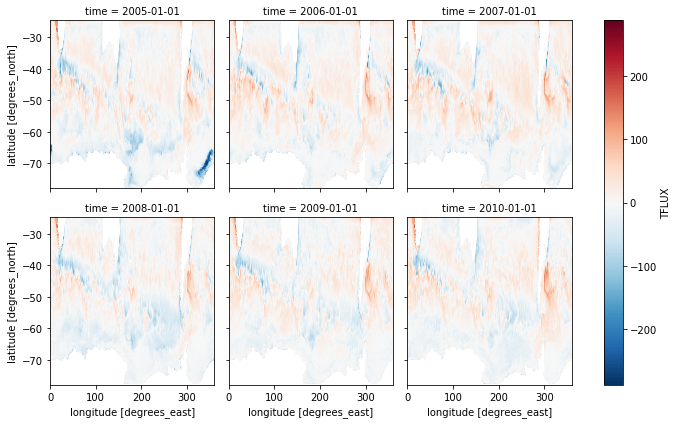

In [287]:
mask = (ds.hFacC.reset_coords(drop=True)[0]>0).load()
qflux = ds.TFLUX.reset_coords(drop=True).resample(time='AS').mean(dim='time').load()
qflux.where(mask).plot(col='time', col_wrap=3)

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)
/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


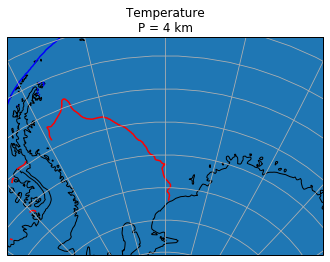

In [308]:
ds = ds_sose

ice = ds_sose.SIarea.sel(time=slice('2006-01-06', '2010-12-31')).where(ds.hFacC[0]>0).reset_coords(drop=True)
ice_clim = ice.groupby('time.month').mean(dim='time').load()
ice_feb = ice_clim.sel(month=2) # minimum ice
ice_oct = ice_clim.sel(month=10) # maximum ice

# load ice data with mask
ice = ds.SIarea.isel(time=0).where(ds.hFacC[0]>0).reset_coords(drop=True).load()

# define a projection for the SOSE coordinates
pc_proj = ccrs.PlateCarree()

# define a projection for the map
central_lon, central_lat = -30, -65
extent = [-60, 0, -80, -60]
ortho_proj = ccrs.Orthographic(central_lon, central_lat)

# plot it 
plt.figure()
#fig, ax = plt.subplots(ncols=2, nrows=2)
ax = plt.axes(projection=ortho_proj)
ax.coastlines(resolution="50m")
ax.set_extent(extent, crs=pc_proj)
ax.gridlines()
#ice.plot(ax=ax, transform=pc_proj, add_colorbar=False)

ice_oct.plot.contour(ax=ax, levels=[0.5], colors='b',
                     transform=pc_proj, add_colorbar=False)
ice_feb.plot.contour(ax=ax, levels=[0.5], colors='r',
                     transform=pc_proj, add_colorbar=False)

group_time_heat.plot(ax=ax, transform=pc_proj)
plt.title('Temperature\nP = 4 km');

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


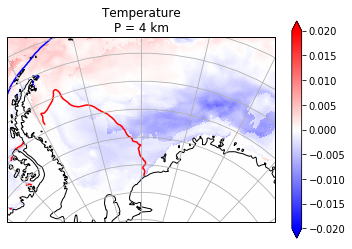

In [307]:
ds = ds_sose

ice = ds_sose.SIarea.sel(time=slice('2006-01-06', '2010-12-31')).where(ds.hFacC[0]>0).reset_coords(drop=True)
ice_clim = ice.groupby('time.month').mean(dim='time').load()
ice_feb = ice_clim.sel(month=2) # minimum ice
ice_oct = ice_clim.sel(month=10) # maximum ice

# load ice data with mask
ice = ds.SIarea.isel(time=0).where(ds.hFacC[0]>0).reset_coords(drop=True).load()

# define a projection for the SOSE coordinates
pc_proj = ccrs.PlateCarree()

# define a projection for the map
central_lon, central_lat = -30, -65
extent = [-60, 0, -80, -60]
ortho_proj = ccrs.Orthographic(central_lon, central_lat)

# plot it 
plt.figure()
#fig, ax = plt.subplots(ncols=2, nrows=2)
ax = plt.axes(projection=ortho_proj)
ax.coastlines(resolution="50m")
ax.set_extent(extent, crs=pc_proj)
ax.gridlines()
#ice.plot(ax=ax, transform=pc_proj, add_colorbar=False)

ice_oct.plot.contour(ax=ax, levels=[0.5], colors='b',
                     transform=pc_proj, add_colorbar=False)
ice_feb.plot.contour(ax=ax, levels=[0.5], colors='r',
                     transform=pc_proj, add_colorbar=False)

buoyancy_flux_heat_4.plot(ax=ax, transform=pc_proj, cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Temperature\nP = 4 km');

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


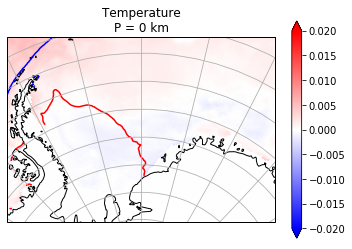

In [304]:
ds = ds_sose

ice = ds_sose.SIarea.sel(time=slice('2006-01-06', '2010-12-31')).where(ds.hFacC[0]>0).reset_coords(drop=True)
ice_clim = ice.groupby('time.month').mean(dim='time').load()
ice_feb = ice_clim.sel(month=2) # minimum ice
ice_oct = ice_clim.sel(month=10) # maximum ice

# load ice data with mask
ice = ds.SIarea.isel(time=0).where(ds.hFacC[0]>0).reset_coords(drop=True).load()

# define a projection for the SOSE coordinates
pc_proj = ccrs.PlateCarree()

# define a projection for the map
central_lon, central_lat = -30, -65
extent = [-60, 0, -80, -60]
ortho_proj = ccrs.Orthographic(central_lon, central_lat)

# plot it 
plt.figure()
#fig, ax = plt.subplots(ncols=2, nrows=2)
ax = plt.axes(projection=ortho_proj)
ax.coastlines(resolution="50m")
ax.set_extent(extent, crs=pc_proj)
ax.gridlines()
#ice.plot(ax=ax, transform=pc_proj, add_colorbar=False)

ice_oct.plot.contour(ax=ax, levels=[0.5], colors='b',
                     transform=pc_proj, add_colorbar=False)
ice_feb.plot.contour(ax=ax, levels=[0.5], colors='r',
                     transform=pc_proj, add_colorbar=False)

buoyancy_flux_heat.plot(ax=ax, transform=pc_proj, cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Temperature\nP = 0 km');

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


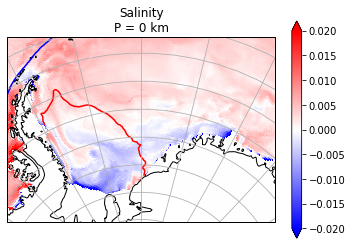

In [303]:
ds = ds_sose

ice = ds_sose.SIarea.sel(time=slice('2006-01-06', '2010-12-31')).where(ds.hFacC[0]>0).reset_coords(drop=True)
ice_clim = ice.groupby('time.month').mean(dim='time').load()
ice_feb = ice_clim.sel(month=2) # minimum ice
ice_oct = ice_clim.sel(month=10) # maximum ice

# load ice data with mask
ice = ds.SIarea.isel(time=0).where(ds.hFacC[0]>0).reset_coords(drop=True).load()

# define a projection for the SOSE coordinates
pc_proj = ccrs.PlateCarree()

# define a projection for the map
central_lon, central_lat = -30, -65
extent = [-60, 0, -80, -60]
ortho_proj = ccrs.Orthographic(central_lon, central_lat)

# plot it 
plt.figure()
#fig, ax = plt.subplots(ncols=2, nrows=2)
ax = plt.axes(projection=ortho_proj)
ax.coastlines(resolution="50m")
ax.set_extent(extent, crs=pc_proj)
ax.gridlines()
#ice.plot(ax=ax, transform=pc_proj, add_colorbar=False)

ice_oct.plot.contour(ax=ax, levels=[0.5], colors='b',
                     transform=pc_proj, add_colorbar=False)
ice_feb.plot.contour(ax=ax, levels=[0.5], colors='r',
                     transform=pc_proj, add_colorbar=False)

buoyancy_flux_salt.plot(ax=ax, transform=pc_proj, cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Salinity\nP = 0 km');

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


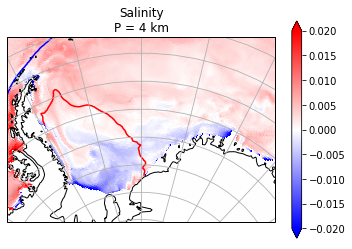

In [302]:
ds = ds_sose

ice = ds_sose.SIarea.sel(time=slice('2006-01-06', '2010-12-31')).where(ds.hFacC[0]>0).reset_coords(drop=True)
ice_clim = ice.groupby('time.month').mean(dim='time').load()
ice_feb = ice_clim.sel(month=2) # minimum ice
ice_oct = ice_clim.sel(month=10) # maximum ice

# load ice data with mask
ice = ds.SIarea.isel(time=0).where(ds.hFacC[0]>0).reset_coords(drop=True).load()

# define a projection for the SOSE coordinates
pc_proj = ccrs.PlateCarree()

# define a projection for the map
central_lon, central_lat = -30, -65
extent = [-60, 0, -80, -60]
ortho_proj = ccrs.Orthographic(central_lon, central_lat)

# plot it 
plt.figure()
#fig, ax = plt.subplots(ncols=2, nrows=2)
ax = plt.axes(projection=ortho_proj)
ax.coastlines(resolution="50m")
ax.set_extent(extent, crs=pc_proj)
ax.gridlines()
#ice.plot(ax=ax, transform=pc_proj, add_colorbar=False)

ice_oct.plot.contour(ax=ax, levels=[0.5], colors='b',
                     transform=pc_proj, add_colorbar=False)
ice_feb.plot.contour(ax=ax, levels=[0.5], colors='r',
                     transform=pc_proj, add_colorbar=False)

buoyancy_flux_salt_4.plot(ax=ax, transform=pc_proj, cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Salinity\nP = 4 km');

In [166]:
ds_sose.time

<xarray.DataArray 'time' (time: 438)>
array(['2005-01-06T00:00:00.000000000', '2005-01-11T00:00:00.000000000',
       '2005-01-16T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [333]:
a0_groupby = alpha_0.groupby('time.month').mean('time')
a0_mean = a0_groupby.mean('month')
a0_mean.load()

In [338]:
a4_groupby = alpha_4.groupby('time.month').mean('time')
a4_mean = a4_groupby.mean('month')
a4_mean.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)
/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (YC: 320, XC: 2160)>
array([[6.619951e-05, 6.619951e-05, 6.619951e-05, ..., 6.619951e-05,
        6.619951e-05, 6.619951e-05],
       [6.619951e-05, 6.619951e-05, 6.619951e-05, ..., 6.619951e-05,
        6.619951e-05, 6.619951e-05],
       [6.619951e-05, 6.619951e-05, 6.619951e-05, ..., 6.619951e-05,
        6.619951e-05, 6.619951e-05],
       ...,
       [1.789723e-04, 1.789635e-04, 1.789555e-04, ..., 1.790019e-04,
        1.789922e-04, 1.789817e-04],
       [1.789748e-04, 1.789659e-04, 1.789575e-04, ..., 1.790033e-04,
        1.789940e-04, 1.789842e-04],
       [1.789730e-04, 1.789635e-04, 1.789540e-04, ..., 1.790014e-04,
        1.789918e-04, 1.789823e-04]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083

In [341]:
b0_groupby = beta_0.groupby('time.month').mean('time')
b0_mean = b0_groupby.mean('month')
b0_mean.load()

<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000816, 0.000816, 0.000816, ..., 0.000816, 0.000816, 0.000816],
       [0.000816, 0.000816, 0.000816, ..., 0.000816, 0.000816, 0.000816],
       [0.000816, 0.000816, 0.000816, ..., 0.000816, 0.000816, 0.000816],
       ...,
       [0.000731, 0.000731, 0.000731, ..., 0.00073 , 0.000731, 0.000731],
       [0.000731, 0.000731, 0.000731, ..., 0.00073 , 0.000731, 0.000731],
       [0.000731, 0.000731, 0.000731, ..., 0.000731, 0.000731, 0.000731]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083

In [340]:
b4_groupby = beta_4.groupby('time.month').mean('time')
b4_mean = b4_groupby.mean('month')
b4_mean.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)
/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000765, 0.000765, 0.000765, ..., 0.000765, 0.000765, 0.000765],
       [0.000765, 0.000765, 0.000765, ..., 0.000765, 0.000765, 0.000765],
       [0.000765, 0.000765, 0.000765, ..., 0.000765, 0.000765, 0.000765],
       ...,
       [0.00073 , 0.00073 , 0.00073 , ..., 0.00073 , 0.00073 , 0.00073 ],
       [0.00073 , 0.00073 , 0.00073 , ..., 0.00073 , 0.00073 , 0.00073 ],
       [0.00073 , 0.00073 , 0.00073 , ..., 0.00073 , 0.00073 , 0.00073 ]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083

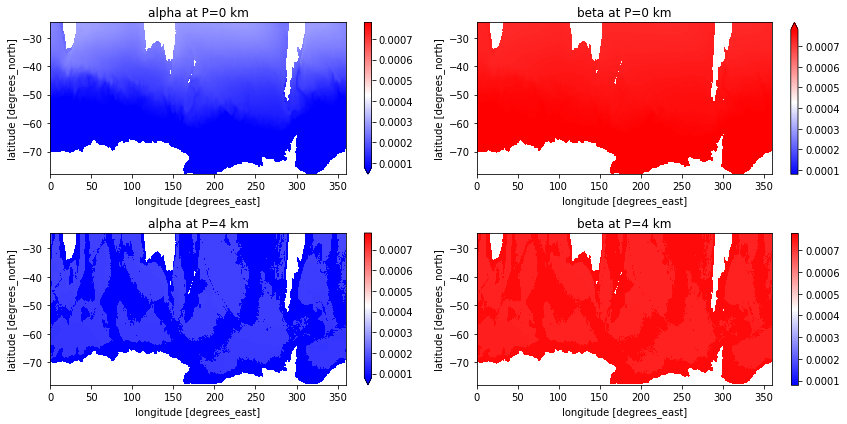

In [346]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,6))

a0_mean.where(ds_sose.hFacC[0]>0).plot(ax=axes[0,0], cmap='bwr', vmin=8e-5, vmax=7.8e-4)
axes[0,0].set_title('alpha at P=0 km')

a4_mean.where(ds_sose.hFacC[0]>0).plot(ax=axes[1,0], cmap='bwr', vmin=8e-5, vmax=7.8e-4)
axes[1,0].set_title('alpha at P=4 km')

b0_mean.where(ds_sose.hFacC[0]>0).plot(ax=axes[0,1], cmap='bwr', vmin=8e-5, vmax=7.8e-4)
axes[0,1].set_title('beta at P=0 km')

b4_mean.where(ds_sose.hFacC[0]>0).plot(ax=axes[1,1], cmap='bwr', vmin=8e-5, vmax=7.8e-4)
axes[1,1].set_title('beta at P=4 km')

plt.tight_layout();

## T/S diagram of Weddell Sea water

In [351]:
ann_mean_heat

<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [2.088118e-06, 2.087656e-06, 2.085921e-06, ..., 2.054297e-06,
        2.067613e-06, 2.081643e-06],
       [2.177557e-06, 2.178507e-06, 2.178935e-06, ..., 2.135719e-06,
        2.150379e-06, 2.167956e-06],
       [2.222973e-06, 2.225556e-06, 2.226918e-06, ..., 2.177259e-06,
        2.191232e-06, 2.210838e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

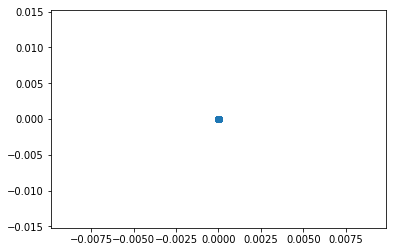

In [353]:
plt.scatter(x=ann_mean_salt.values, y=ann_mean_heat.values)

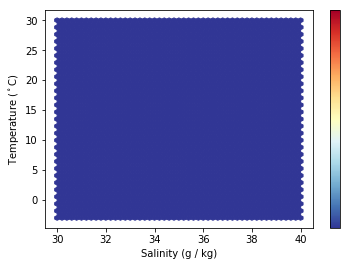

In [356]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
hb = ax.hexbin(ann_mean_salt.values.ravel(), ann_mean_heat.values.ravel(),
           #C=vol.values.ravel(), reduce_C_function=np.sum,
           extent=(30,40,-3,30), gridsize=50, bins='log',
           cmap='RdYlBu_r')
plt.colorbar(hb)
ax.set_ylabel(r'Temperature ($^\circ$C)')
ax.set_xlabel("Salinity (g / kg)")
hb.set_clim([12,18])

In [206]:
ds_sose.THETA.Z.values

array([-5.0000e+00, -1.5500e+01, -2.7000e+01, -3.9500e+01, -5.3000e+01,
       -6.8000e+01, -8.5000e+01, -1.0400e+02, -1.2550e+02, -1.5000e+02,
       -1.7750e+02, -2.0850e+02, -2.4350e+02, -2.8300e+02, -3.2800e+02,
       -3.7950e+02, -4.3850e+02, -5.0600e+02, -5.8300e+02, -6.7100e+02,
       -7.7200e+02, -8.8800e+02, -1.0210e+03, -1.1735e+03, -1.3485e+03,
       -1.5495e+03, -1.7805e+03, -2.0460e+03, -2.3190e+03, -2.5750e+03,
       -2.8250e+03, -3.0750e+03, -3.3250e+03, -3.5750e+03, -3.8250e+03,
       -4.0750e+03, -4.3250e+03, -4.5750e+03, -4.8250e+03, -5.0750e+03,
       -5.3250e+03, -5.5750e+03], dtype=float32)

In [372]:
sst_avg = ds_sose.THETA.mean(dim='Z')
sss_avg = ds_sose.SALT.mean(dim='Z')

sst_reg = ds_sose.THETA
sss_reg = ds_sose.SALT

In [373]:
#converting practical salinity to absolute salinity
sa_avg = xr.apply_ufunc(gsw.SA_from_SP, sss_reg, 2500, ds_sose.XC, ds_sose.YC,
                    output_dtypes=[sss_avg.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_avg

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [374]:
#converting potential temperature to conservative temperature
ct_avg = xr.apply_ufunc(gsw.CT_from_pt, sa_avg, sst_reg,
                    output_dtypes=[sss_avg.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct_avg

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [375]:
sa_group_avg = sa_avg.groupby('time.month').mean('time')
sa_time_avg = sa_group_avg.mean('month')

ct_group_avg = ct_avg.groupby('time.month').mean('time')
ct_time_avg = ct_group_avg.mean('month')

In [376]:
sa_time_avg.load()

<xarray.DataArray (Z: 42, YC: 320, XC: 2160)>
array([[[ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        ...,
        [ 3.612262e+01,  3.611351e+01, ...,  3.614067e+01,  3.613163e+01],
        [ 3.611841e+01,  3.610929e+01, ...,  3.613653e+01,  3.612741e+01]],

       [[ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        ...,
        [ 3.612134e+01,  3.611226e+01, ...,  3.613935e+01,  3.613033e+01],
        [ 3.611656e+01,  3.610749e+01, ...,  3.613457e+01,  3.612551e+01]],

       ...,

       [[ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        ...,
        [ 3.506670e+01,  3.506672e+01, ..., -1.413354e-08,  0.000000e+00],
        [ 3.506674e+01,  3.506673e+01, ...,  0.000000e+00,  0.000000e+00]

In [377]:
ct_time_avg.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)
/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (Z: 42, YC: 320, XC: 2160)>
array([[[1.528448e-02, 1.528448e-02, ..., 1.528448e-02, 1.528448e-02],
        [1.528448e-02, 1.528448e-02, ..., 1.528448e-02, 1.528448e-02],
        ...,
        [2.078580e+01, 2.075717e+01, ..., 2.084208e+01, 2.081400e+01],
        [2.076676e+01, 2.073845e+01, ..., 2.082330e+01, 2.079498e+01]],

       [[1.528448e-02, 1.528448e-02, ..., 1.528448e-02, 1.528448e-02],
        [1.528448e-02, 1.528448e-02, ..., 1.528448e-02, 1.528448e-02],
        ...,
        [2.073847e+01, 2.071020e+01, ..., 2.079440e+01, 2.076650e+01],
        [2.070025e+01, 2.067239e+01, ..., 2.075608e+01, 2.072822e+01]],

       ...,

       [[1.528448e-02, 1.528448e-02, ..., 1.528448e-02, 1.528448e-02],
        [1.528448e-02, 1.528448e-02, ..., 1.528448e-02, 1.528448e-02],
        ...,
        [1.967473e+00, 1.967440e+00, ...,          nan, 1.528448e-02],
        [1.967613e+00, 1.967603e+00, ..., 1.528448e-02, 1.528448e-02]],

       [[1.528448e-02, 1.528448e-02, ..., 1.

In [387]:
sa_time_avg.max()

<xarray.DataArray ()>
array(47.764088, dtype=float32)

In [386]:
ct_time_avg.max()

<xarray.DataArray ()>
array(25.794458, dtype=float32)

In [385]:
sa_time_avg.min()

<xarray.DataArray ()>
array(-0.004337, dtype=float32)

In [384]:
ct_time_avg.min()

<xarray.DataArray ()>
array(-1.940054, dtype=float32)

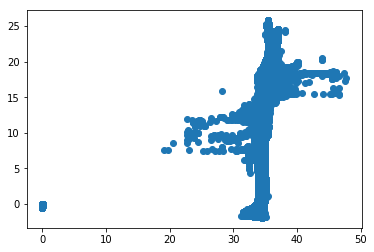

In [394]:
plt.scatter(x=sa_time_avg, y=ct_time_avg)

In [166]:
#masking land '.where(ds_sose.hFacC)'

zonal_mean_temp0 = buoyancy_flux_heat.where(ds_sose.hFacC[0]).mean(dim='XC').sel(YC=slice(-80,-40))
zonal_mean_temp2 = buoyancy_flux_heat_2.where(ds_sose.hFacC[0]).mean(dim='XC').sel(YC=slice(-80,-40))
zonal_mean_temp3 = buoyancy_flux_heat_3.where(ds_sose.hFacC[0]).mean(dim='XC').sel(YC=slice(-80,-40))
zonal_mean_temp4 = buoyancy_flux_heat_4.where(ds_sose.hFacC[0]).mean(dim='XC').sel(YC=slice(-80,-40))

zonal_mean_salt0 = buoyancy_flux_salt.where(ds_sose.hFacC[0]).mean(dim='XC').sel(YC=slice(-80,-40))
zonal_mean_salt2 = buoyancy_flux_salt_2.where(ds_sose.hFacC[0]).mean(dim='XC').sel(YC=slice(-80,-40))
zonal_mean_salt3 = buoyancy_flux_salt_3.where(ds_sose.hFacC[0]).mean(dim='XC').sel(YC=slice(-80,-40))
zonal_mean_salt4 = buoyancy_flux_salt_4.where(ds_sose.hFacC[0]).mean(dim='XC').sel(YC=slice(-80,-40))

In [167]:
zonal_mean = xr.merge([zonal_mean_temp0.to_dataset(name='zonal_mean_temp0'),
                       zonal_mean_temp2.to_dataset(name='zonal_mean_temp2'),
                       zonal_mean_temp3.to_dataset(name='zonal_mean_temp3'),
                       zonal_mean_temp4.to_dataset(name='zonal_mean_temp4'),
                       zonal_mean_salt0.to_dataset(name='zonal_mean_salt0'),
                       zonal_mean_salt2.to_dataset(name='zonal_mean_salt2'),
                       zonal_mean_salt3.to_dataset(name='zonal_mean_salt3'),
                       zonal_mean_salt4.to_dataset(name='zonal_mean_salt4')])
zonal_mean

<xarray.Dataset>
Dimensions:           (YC: 228)
Coordinates:
  * YC                (YC) float32 -77.87497 -77.7083 ... -40.208298 -40.041634
    PHrefC            float32 dask.array<shape=(), chunksize=()>
    Z                 float32 -5.0
    drF               float32 dask.array<shape=(), chunksize=()>
Data variables:
    zonal_mean_temp0  (YC) float32 dask.array<shape=(228,), chunksize=(228,)>
    zonal_mean_temp2  (YC) float32 dask.array<shape=(228,), chunksize=(228,)>
    zonal_mean_temp3  (YC) float32 dask.array<shape=(228,), chunksize=(228,)>
    zonal_mean_temp4  (YC) float32 dask.array<shape=(228,), chunksize=(228,)>
    zonal_mean_salt0  (YC) float32 dask.array<shape=(228,), chunksize=(228,)>
    zonal_mean_salt2  (YC) float32 dask.array<shape=(228,), chunksize=(228,)>
    zonal_mean_salt3  (YC) float32 dask.array<shape=(228,), chunksize=(228,)>
    zonal_mean_salt4  (YC) float32 dask.array<shape=(228,), chunksize=(228,)>

Text(0, 0.5, 'buoyancy flux mm$^{2} / s^{3}$')

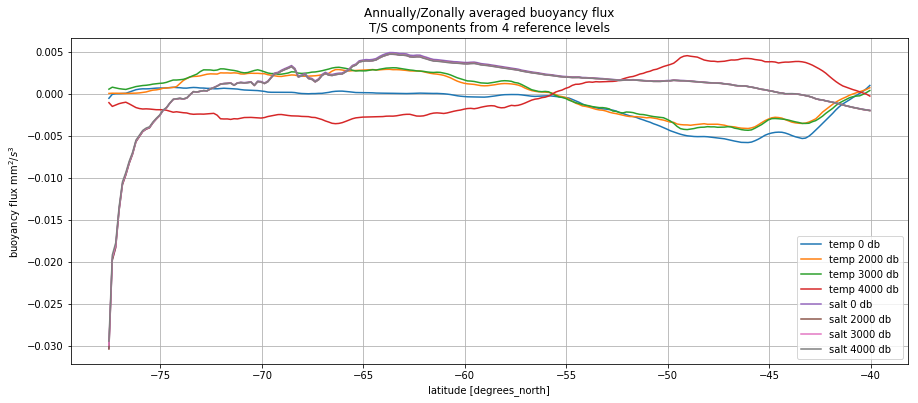

In [171]:
plt.figure(figsize=(15, 6))

zonal_mean.zonal_mean_temp0.plot(label='temp 0 db')
zonal_mean.zonal_mean_temp2.plot(label='temp 2000 db')
zonal_mean.zonal_mean_temp3.plot(label='temp 3000 db')
zonal_mean.zonal_mean_temp4.plot(label='temp 4000 db')
zonal_mean.zonal_mean_salt0.plot(label='salt 0 db')
zonal_mean.zonal_mean_salt2.plot(label='salt 2000 db')
zonal_mean.zonal_mean_salt3.plot(label='salt 3000 db')
zonal_mean.zonal_mean_salt4.plot(label='salt 4000 db')
plt.legend()
plt.grid()
plt.title('Annually/Zonally averaged buoyancy flux\nT/S components from 4 reference levels')
plt.ylabel("buoyancy flux mm$^{2} / s^{3}$")

No handles with labels found to put in legend.


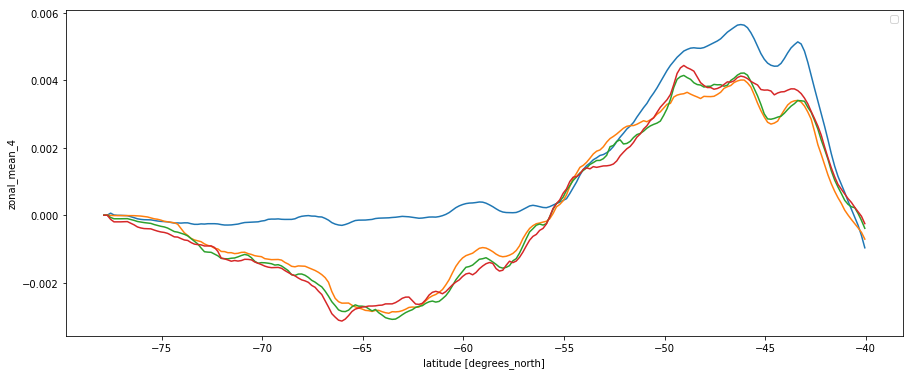

In [142]:
plt.figure(figsize=(15,6))
for dvar in zonal_mean.data_vars:
    zonal_mean[dvar].plot()
plt.legend()

# Past Efforts below for trying what is achieved above
Best not to delete these so that you can look back on your though process and see the progression

In [ ]:
F_sigma_p0 = F_sig_heat + F_sig_salt
F_sigma_p0

In [ ]:
F_sigma_p0[0].plot(cmap='bwr')

In [ ]:
ds_sose.SFLUX.units

In [ ]:
ds_sose.TFLUX.long_name

In [ ]:
print(ds_sose.SFLUX, ds_sose.TFLUX)

$$
F_{\sigma} = F_{heat}\frac{\partial\sigma}{\partial\theta} + F_{salt}\frac{\partial\sigma}{\partial S}\
$$

$$
where
$$

$$
F_{heat} = \frac{\partial \theta}{\partial t}\ is\ the\ heat\ flux
$$

$$
F_{salt} = \frac{\partial \theta}{\partial t}\ is\ the\ salt\ flux
$$

$$
where\ \frac{\partial\sigma}{\partial\theta} \sim \alpha = -\frac{1}{\rho_0}\frac{\partial\rho}{\partial\theta}\ is\ the\ thermal\ expansion\ coefficient
$$

$$
where\ \frac{\partial\sigma}{\partial S} \sim \beta = \frac{1}{\rho_0}\frac{\partial\rho}{\partial S}\ is\ the\ haline\ contraction\ coefficient 
$$

In [ ]:
#multiply by another rho because of definition of rho
F_sigma = (ds_sose.TFLUX / (runit2mass*heat_capacity_cp))*alpha + (ds_sose.SFLUX / runit2mass)*beta
F_sigma

In [ ]:
F_sigma['time']

In [ ]:
F_sigma.time

In [ ]:
ds_sose.TFLUX

In [ ]:
group_time = F_sigma.groupby('time.month').mean(dim='time')
group_time

In [ ]:
with ProgressBar():
    ann_mean = group_time.mean(dim='month')
    ann_mean.load()

In [ ]:
ann_mean.plot()
plt.title('density flux\nunits: kg/m^2/s')

1. So from here try to first convert this density flux map to buoyancy flux by multiplying it by g/rho
2. then convert m^2 to mm^2
3. See if this matches Ferrari's figure 3 and then if it does change pressure to 3 other reference pressures then see how they change!

In [ ]:
#to go from density flux to buoyancy flux multiply by (-g/rho)
ferrari = ann_mean*(-9.81/1035)*10e6
ferrari

In [ ]:
#still off by a factor of 100 - maybe that comes from the g to kg conversion for SFLUX term in F_sigma?
#colors seem inverted
(100*ferrari).sel(YC=slice(-80,-40)).plot(figsize=(15,7), cmap='bwr', vmin=-0.02, vmax=0.02)
#plt.pcolormesh(edgecolors='white')
plt.title('Ferrari Fig.3 of Annual Mean Buoyancy Flux\nP=0');

In [ ]:
#For ECCO Model
cat = intake.Catalog('https://raw.githubusercontent.com/pangeo-data/pangeo_ocean_examples/master/catalog.yaml')
ds_ecco = cat.ECCOv4r3.to_dask()
#ds_ecco

In [ ]:
#For SOSE Model
cat = intake.Catalog('https://raw.githubusercontent.com/pangeo-data/pangeo_ocean_examples/master/catalog.yaml')
ds = cat.SOSE.to_dask()
ds

In [ ]:
#to make things more efficient only pull the variables you want to work with
vars_i_want = ['SFLUX', 'TFLUX', 'SALT', 'THETA']
my_ds = ds[vars_i_want].isel(Z=0)
my_ds

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    my_ds.load()

In [ ]:
my_ds.nbytes/1e9

In [ ]:
ds.XG

In [ ]:
for vname in ds.data_vars:
    print(vname, ds[vname].attrs["long_name"], ds[vname].attrs["units"])

In [ ]:
ds.PHrefC

In [ ]:
ds.SFLUX

In [ ]:
ds.SALT

$$
\frac{D\sigma}{Dt} = \dot{\sigma_{\theta}} = \frac{\partial\sigma_{\theta}}{\partial\theta}\dot{\theta} + \frac{\partial\sigma_{\theta}}{\partial S}\dot{S}
$$

$$
where\ \dot{\theta} = \frac{D\theta}{Dt} = G^{\theta}_{hdiff} + G^{\theta}_{vdiff} + G^{\theta}_{KPP} + G^{\theta}_{surf} + G^{\theta}_{sw}
$$

$$
where\ \dot{S} = \frac{DS}{Dt} = G^{S}_{hdiff} + G^{S}_{vdiff} + G^{S}_{KPP} + G^{S}_{surf}
$$

$$
where\ \frac{\partial\sigma}{\partial\theta} = 
$$

$$
where\ \frac{\partial\sigma}{\partial S} = 
$$

$$
Isopycnal\ Slope:
s \simeq \frac{\tau}{\rho_{0}fK}
$$
Ferrari et al. (2014) **PNAS**

In [ ]:
tau = 0.1 #N/m^2
rho_0 = 1027 #kg/m^3
f = 2*7.2921e-5*np.sin(-65)
K = 1000 #m^2/s Eddy diffusivity

In [ ]:
taux = ds.oceTAUX
taux

In [ ]:
taux.sel(YC=-65, method='nearest').plot();

In [ ]:
taux_65S = taux.sel(YC=-65, method='nearest')
taux_65S.mean(dim='XG').plot()
plt.title('Zonally averaged taux at -65˚S');

In [ ]:
taux.mean(dim=('XG', 'time')).plot()

In [ ]:
strata = taux.mean(dim=('XG', 'time'))
strata

In [ ]:
ds.PHrefF.plot()

In [ ]:
ds.ADVy_SLT

In [ ]:
ds.ADVy_TH

In [ ]:
plt.figure(figsize=(10,10))
extent = [-180, 180, -80, -55]
central_lon = np.mean(extent[:2])
#central_lat = np.mean(extent[2:])

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_lon))
ax.coastlines(resolution='50m')
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

In [ ]:
plt.figure(figsize=(10,10))
extent = [-180, 180, -80, -55]
#central_lon = np.mean(extent[:2])
#central_lat = np.mean(extent[2:])

ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines(resolution='50m')
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')